# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''
from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Define function to retrieve spike depths along the probe using template waveforms '''

def get_spike_depths(temps, winv, ycoords, spikeTemplates):
    
    ''' 
    Compute spike depths for each cluster

    Params
    ------ 
    temps: the templates (nTemplates x nTimePoints x nChannels)
    winv: the whitening matrix (nCh x nCh)
    ycoords: the coordinates of the channels (nCh x 1)
    spikeTemplates: which template each spike came from (nSpikes x 1)

    Returns
    --------
    spikeDepths is the position along the probe of every spike, (nSpikes x 1)
    according to the position of the template it was extracted with. Distance in microns from tip.

    '''
    #unwhiten all templates
    tempsUnW = np.zeros(shape = (temps.shape[0],temps.shape[1],temps.shape[2]))
    for t in range(0,temps.shape[0]):
        tempsUnW[t,:,:] = np.matmul(temps[t,:,:],winv)

    #get the amplitude on each channel as the max minus min in timepoints (shape nTemp x nCh)
    tempChanAmps = np.max(tempsUnW, axis = 1) - np.min(tempsUnW, axis = 1)

    #the template amplitude is the amplitude of the largest channel 
    tempAmpsUnscaled = np.max(tempChanAmps, axis = 1) #shape nTemp

    #zero out potentially many low values on distant channels; for every channel if below amp 
    threshVals = tempAmpsUnscaled*0.3
    for i in range(0,tempChanAmps.shape[1]):
        for j in range(0,len(threshVals)):
            if tempChanAmps[j,i] < threshVals[j]:
                tempChanAmps[j,i] = 0

    #compute template depth as a center of mass
    templateDepths = np.sum(tempChanAmps*ycoords, axis = 1) / (np.sum(tempChanAmps, axis = 1))

    #each spikes depth is the depth of its template
    spikeDepths = templateDepths[templates]
    
    return spikeDepths

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [6]:
'''Load Session Metadata'''
sessionmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/SessionMetadata.csv') # adjust path name

In [7]:
''' Complete List of Mice & Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [8]:
'''Define which mice & sessions to load'''
mice = all_mice
sessions = all_sessions
    
# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [9]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedscores/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedstabscores/' # adjust to match location of this Dryad repo folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Figure S2 output folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure6/' 

In [10]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [11]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Classify positively and negatively speed-tuned (+ / - speed) cells 

In [14]:
''' Calculate & Save Real Speed Scores & Speed Stability Scores '''
realspeedscores = []
realspeedstabscores = []
dt = 0.02
sigma = 20  # smoothing factor for instantaneous firing rate
n_bin = 8 #n position bins considered for speed stability score
track_length = 400 #cm
bins = np.arange(0,track_length + (track_length/n_bin),(track_length/n_bin))

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posxfil = behaviorfil[:,0]
        Y = np.load(load_folder + spikes_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        speed = behaviorfil[:,1] #already filtered through gaussian (10 timebins) 
        
        # divide all obs into 8 x 50 cm bins
        bin_idx = []
        for i in range(n_bin):
            if i == (n_bin - 1):
                idx = np.where((posxfil >= bins[i]) & (posxfil <= bins[i + 1]))[0]
            else:
                idx = np.where((posxfil >= bins[i]) & (posxfil < bins[i + 1]))[0]
            bin_idx.append(idx)
        
        #get smoothed spike train, calculate speed score
        A = np.zeros((len(speed), len(cell_IDs)))
        realspeed_score = []
        realspeedstab_score = []
        for i, c in enumerate(cell_IDs):
            A[:,i] = Y[:,i]
            A[:,i] = gaussian_filter1d(A[:,i],sigma)
            
            #calculate speed score
            sscore, _ = stats.pearsonr(A[:,i],speed)
            realspeed_score = np.append(realspeed_score,sscore)
            
            #calculate & store speed stability score for this cell's smoothed spike train
            bin_pspikes = []
            for j in range(n_bin):
                idx = bin_idx[j]
                psscore, _ = stats.pearsonr(A[idx,i],speed[idx])
                bin_pspikes = np.append(bin_pspikes, (psscore *  np.sum(A[idx,i])))

            sstabscore = np.sum(bin_pspikes) / np.sum(A[:,i])
            realspeedstab_score = np.append(realspeedstab_score,sstabscore)
            
        d['speedscore'] = realspeed_score
        d['speedstabscore'] = realspeedstab_score
        d['A'] = A

        #Save stuff
        realinstspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'
        
        np.save(save_folder + realinstspeedscore_file, realspeed_score)
        #print('saved real speed score data as npy file for mouse ' + m + ' session '+ s)
        np.save(save_folder + realspeedstabscore_file, realspeedstab_score)
        #print('saved real speed stability score data as npy file for mouse ' + m + ' session '+ s)
        np.save(save_folder + A_file, A)
        #print('saved filtered, binned spikes as npy file for mouse ' + m + ' session '+ s)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
'''Load Scores & Save Booleans of Negative & Positively Modulated Speed Cells 
  
 NOTE: shuffled scores are produced by the notebook "Shuffle Procedure." Please run that for all sessions before proceeding here.

'''  

P99score = []
P99stabscore = []
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        realspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #Load stuff & get data relevant to classification
        d['speedscore'] = np.load(save_folder + realspeedscore_file)
        d['speedstabscore'] = np.load(save_folder + realspeedstabscore_file)
        d['shufspeedscore'] = np.load(shuffload_folder1 + shufinstspeedscore_file, allow_pickle = True) 
        d['shufspeedstabscore'] = np.load(shuffload_folder2 + shufspeedstabscore_file, allow_pickle = True) 
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        cell_IDs = raw.item().get('cellsfil')
        
        speedcell99 = []
        speedcell1 = []
        
        #Classify excitatory, positively & negatively modulated speed cells
        for i, c in enumerate(cell_IDs):
            dist = abs(shufspeedscore[:,i])
            P99 = np.percentile(dist,99)
            
            dist2 = abs(shufspeedstabscore[:,i])
            sP99 = np.percentile(dist2,99)
            
            P99stabscore = np.append(P99stabscore, sP99)
            P99score = np.append(P99score, P99)

            if (abs(realspeed_score[i]) >= P99) & (abs(realspeedstab_score[i]) >= sP99):
                if realspeed_score[i] >= 0: # pos mod P99 cell
                    speedcell99 = np.append(speedcell99, True)
                    speedcell1 = np.append(speedcell1, False)
                else: # neg mod P99 cell
                    speedcell99 = np.append(speedcell99, False)
                    speedcell1 = np.append(speedcell1, True) 
            else:
                speedcell99 = np.append(speedcell99, False)
                speedcell1 = np.append(speedcell1, False) 

        speedcell99 = np.asarray(speedcell99).astype(bool)
        speedcell1 = np.asarray(speedcell1).astype(bool)
                
        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedcell99'] = speedcell99
        d['speedcell1'] = speedcell1
        
        speedcell99_file = 'speedcell99_' + m + '_' + s + '.npy'
        speedcell1_file = 'speedcell1_' + m + '_' + s + '.npy'
        
        np.save(save_folder + speedcell99_file, speedcell99)
        np.save(save_folder + speedcell1_file, speedcell1)
        #print('saved all speed cell booleans as npy files for mouse ' + m + ' session '+ s)

In [13]:
''' Total of Cells of Each Type by Age Group at P99 Thresholds'''

ypos = 0
mapos = 0
apos = 0

yneg = 0
maneg = 0
aneg = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        poscell = d['speedcell99']
        negcell = d['speedcell1']
        
        poscell = poscell.astype(bool)
        negcell = negcell.astype(bool)
        
        if (m in all_aged_mice):
            apos += np.sum(poscell)
            aneg += np.sum(negcell)
        elif m in SM_MA_mice:
            mapos += np.sum(poscell)
            maneg += np.sum(negcell)
        else:
            ypos += np.sum(poscell)
            yneg += np.sum(negcell)
            
print(ypos, mapos, apos)
print(yneg, maneg, aneg)

6522 4062 6507
3085 2071 2912


# Examine speed tuning among classified speed cells (Figures 6A-E)

A3 0122_record1 544


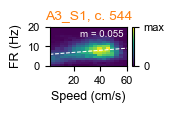

Y18 062222_record3 58


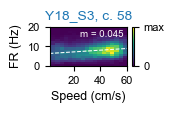

MA1F 102522_record3 965


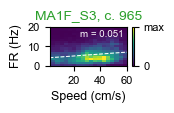

In [14]:
''' Plot Single, Labeled 2D Heat Maps for Representative + Speed Cells (Figure 6A top row panels)'''

ex_mice = ['Y18','MA1F','A3']
ex_sessions = ['062222_record3','102522_record3','0122_record1']
ex_cells = [544, 58, 965]
count = 0
dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in session:
        
        if (m not in ex_mice) or (s not in ex_sessions):
            continue
        
        d = data[m][s]
    
        #get file names & load data necessary
        A_file = 'A_' + m + '_' + s + '.npy'
        A = np.load(save_folder + A_file)
        A = A / dt
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        # ID excitatory speed tuned cells as +/- speed cells
        cell_IDs = raw.item().get('cellsfil')
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        x_bins = np.linspace(0,60,20)
        y_bins = np.linspace(0,20,20)
        
        if m in all_young_mice: 
            col = 'C0'
        elif m in all_aged_mice:
            col = 'C1'
        else:
            col = 'C2'
                
        for i, c in enumerate(speedcells99): #plots three example cells per session
        
            try:  #handles trivial indexing issue for ex_cells list   
                if (c == ex_cells[count]):
                    
                    print(m,s,c)

                    sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                    slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])

                    #plot 2D histogram / heatmap
                    fig, ax = plt.subplots(figsize = (1.25,0.5))

                    h = ax.hist2d(speed, A[:,sdx], bins = [x_bins, y_bins])
                    cbar = fig.colorbar(h[3], ax=ax, ticks = [0,np.max(h[0])])
                    cbar.ax.set_yticklabels(['0','max'])
                    cbar.ax.tick_params(labelsize = 8)

                    ax.set_title(str(m) + '_S' + str(s[-1]) + ', c. ' + str(c), fontsize = 10, color = col)
                    ax.text(x = 25, y = 15, s = 'm = ' + str(np.round(slopeFR, 3)), color = 'w', fontsize = 7)
                    ax.tick_params(labelsize = 8)
                    plt.xlabel('Speed (cm/s)', fontsize = 9)
                    plt.ylabel('FR (Hz)', fontsize = 9)

                    #overlay correlation line
                    plt.xlim([2,60])
                    ax.set_xticks([20,40,60])
                    ax.set_yticks([0,10,20])
                    plt.ylim([0,20])
                    X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
                    plt.plot(X_plot, slopeFR*X_plot + intFR, '--', color = 'w', linewidth = 0.75)
                    plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_6Atoprow.png', dpi = 400, bbox_inches = 'tight')
                    plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_6Atoprow.svg', dpi = 400, bbox_inches = 'tight')
                    plt.show()

                    count += 1
            except:
                continue

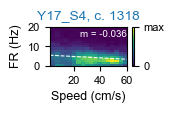

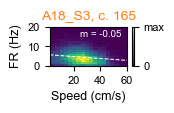

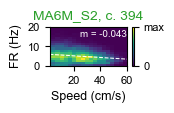

In [15]:
''' Plot Single, Labeled 2D Heat Maps for Representative - Speed Cells (Figure 6A bottom row panels)'''

ex_mice = ['Y17','MA6M','A18']
ex_sessions = ['070122_record4','103122_record2','082522_record3']
ex_cells = [1318,165,394]
count = 0
dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in session:
        
        if (m not in ex_mice) or (s not in ex_sessions):
            continue
        
        d = data[m][s]
    
        #get file names & load data necessary
        A_file = 'A_' + m + '_' + s + '.npy'
        A = np.load(save_folder + A_file)
        A = A / dt
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posx = behaviorfil[:,0]
        speed = behaviorfil[:,1]
        
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        # ID excitatory speed tuned cells as +/- speed cells
        cell_IDs = raw.item().get('cellsfil')
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        x_bins = np.linspace(0,60,20)
        y_bins = np.linspace(0,20,20)

        if m in all_young_mice: 
            col = 'C0'
        elif m in all_aged_mice:
            col = 'C1'
        else:
            col = 'C2'
                
        for i, c in enumerate(speedcells1): #plots three example cells per session
        
            try:  #handles trivial indexing issue for ex_cells list   
                if (c == ex_cells[count]):

                    sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                    slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])

                    #plot 2D histogram / heatmap
                    fig, ax = plt.subplots(figsize = (1.25,0.5))

                    h = ax.hist2d(speed, A[:,sdx], bins = [x_bins, y_bins])
                    cbar = fig.colorbar(h[3], ax=ax, ticks = [0,np.max(h[0])])
                    cbar.ax.set_yticklabels(['0','max'])
                    cbar.ax.tick_params(labelsize = 8)

                    ax.set_title(str(m) + '_S' + str(s[-1]) + ', c. ' + str(c), fontsize = 10, color = col)
                    ax.text(x = 25, y = 15, s = 'm = ' + str(np.round(slopeFR, 3)), color = 'w', fontsize = 7)
                    ax.tick_params(labelsize = 8)
                    plt.xlabel('Speed (cm/s)', fontsize = 9)
                    plt.ylabel('FR (Hz)', fontsize = 9)

                    #overlay correlation line
                    plt.xlim([2,60])
                    ax.set_xticks([20,40,60])
                    ax.set_yticks([0,10,20])
                    plt.ylim([0,20])
                    X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
                    plt.plot(X_plot, slopeFR*X_plot + intFR, '--', color = 'w', linewidth = 0.75)
                    plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_6Abottomrow.png', dpi = 400, bbox_inches = 'tight')
                    plt.savefig(save_folder + str(m) + '_' + str(s) + '_' + str(c) + '_6Abottomrow.svg', dpi = 400, bbox_inches = 'tight')
                    plt.show()

                    count += 1
            except:
                continue

In [14]:
''' For positive and negatively modulated, excitatory speed cells, plot distribution of scores vs. shuffle in separate colors '''

posscore = []
posshuffscore = []
posstabscore = []
posshuffstabscore = []
negscore = []
negshuffscore = []
negstabscore = []
negshuffstabscore = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        speedcell99 = d['speedcell99'].astype(bool)
        speedcell1 = d['speedcell1'].astype(bool)
        
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)

        #get cell IDs, filtered behavioral/spike data, & relevant score
        poscells = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        negcells = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        for i, c in enumerate(poscells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffscore = np.random.choice(np.ravel(shufspeedscore[:,sdx]))
            shuffstabscore = np.random.choice(np.ravel(shufspeedstabscore[:,sdx]))
            stabscore = realspeedstab_score[sdx]
            score = realspeed_score[sdx]
            
            posscore = np.append(posscore,score)
            posshuffscore = np.append(posshuffscore,shuffscore)
            posstabscore = np.append(posstabscore,stabscore)
            posshuffstabscore = np.append(posshuffstabscore,shuffstabscore)
            
        for i, c in enumerate(negcells):
            sdx = np.where(cell_IDs == c)[0][0]
            
            shuffscore = np.random.choice(np.ravel(shufspeedscore[:,sdx]))
            shuffstabscore = np.random.choice(np.ravel(shufspeedstabscore[:,sdx]))
            stabscore = realspeedstab_score[sdx]
            score = realspeed_score[sdx]

            negscore = np.append(negscore,score)
            negshuffscore = np.append(negshuffscore,shuffscore)
            negstabscore = np.append(negstabscore,stabscore)
            negshuffstabscore = np.append(negshuffstabscore,shuffstabscore)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


n pos speed cells, neg speed cells: 
11528 6548


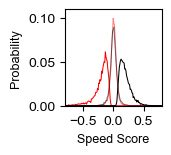


Pos Speed Scores, Real vs. Shuffle Pairs:
mean, SEM + speed cell score:
0.19283799920635647 0.0008566168440621046
mean, SEM shuffle + speed cell stab score:
-0.0005410105556891933 0.0005391431567817507
stat = 999.0
p_cells = 0.0

Neg Speed Scores, Real vs. Shuffle Pairs:
mean, SEM - speed cell score:
-0.2010307096306674 0.0014573509990108288
mean, SEM shuffle - speed cell score:
-6.841046141160961e-05 0.0006480980701365731
stat = 43.0
p_cells = 0.0

Pos vs. Neg Speed Scores:
stat = -111.92542898749825
p_cells = 0.0


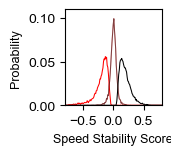


Pos Speed Stability Scores, Real vs. Shuffle Pairs:
mean, SEM + speed cell stab score:
0.1935772397943404 0.0008593708427473876
mean, SEM shuffle + speed cell stab score:
-0.0005392633290843213 0.0005522763447455658
stat = 8746.0
p_cells = 0.0

Neg Speed Stability Scores, Real vs. Shuffle Pairs:
mean, SEM - speed cell stab score:
-0.20244188860287415 0.0014551207451516494
mean, SEM shuffle - speed cell stab score:
-0.002412211735482515 0.0006621293293474364
stat = 8368.0
p_cells = 0.0

Pos vs. Neg Stability Scores:
stat = -111.8877317080558
p_cells = 0.0


In [15]:
''' For pos/neg speed cells, plot distribution of randomly selected shuffles vs. real score/stabscore (Plot Figure 6b-c) '''

print('\nn pos speed cells, neg speed cells: ')
print(len(posstabscore), len(negstabscore))

# Plot Figure 6b
fig, ax = plt.subplots(figsize = (1.25,1.25))
bins = np.arange(-1,1,0.01)

#negative cells
bscore, bin_edges = np.histogram(negscore, bins = bins)
pdf = bscore / sum(bscore)

shuffbscore, shuffbin_edges = np.histogram(negshuffscore, bins = bins)
shuffpdf = shuffbscore / sum(shuffbscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'r')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'r', alpha = 0.5)

#positive cells
score, bin_edges = np.histogram(posscore, bins = bins)
pdf = score / sum(score)

shuffscore, shuffbin_edges = np.histogram(posshuffscore, bins = bins)
shuffpdf = shuffscore / sum(shuffscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)

#format plot
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Speed Score', fontsize = 9)
ax.set_xlim([-0.8,0.8])
ax.set_ylim([0,0.11])
plt.savefig(save_folder + '6B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6B.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS for Figure 6b
#score pos VS SHUFF
print('\nPos Speed Scores, Real vs. Shuffle Pairs:')
print('mean, SEM + speed cell score:')
print(np.nanmean(posscore), stats.sem(posscore, nan_policy = 'omit')) 
print('mean, SEM shuffle + speed cell stab score:')
print(np.nanmean(posshuffscore), stats.sem(posshuffscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(posscore, posshuffscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#score neg VS SHUFF
print('\nNeg Speed Scores, Real vs. Shuffle Pairs:')
print('mean, SEM - speed cell score:')
print(np.nanmean(negscore), stats.sem(negscore, nan_policy = 'omit')) 
print('mean, SEM shuffle - speed cell score:')
print(np.nanmean(negshuffscore), stats.sem(negshuffscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(negscore[~np.isnan(negshuffscore)], negshuffscore[~np.isnan(negshuffscore)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#score pos VS neg
print('\nPos vs. Neg Speed Scores:')
stat, p_diff = stats.ranksums(negscore, posscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

# Plot Figure 6c
fig, ax = plt.subplots(figsize = (1.25,1.25))

#negative cells
bstabscore, bin_edges = np.histogram(negstabscore, bins = bins)
pdf = bstabscore / sum(bstabscore)

shuffstabscore, shuffbin_edges = np.histogram(negshuffstabscore, bins = bins)
shuffpdf = shuffstabscore / sum(shuffstabscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'r')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'r', alpha = 0.5)

#positive cells
stabscore, bin_edges = np.histogram(posstabscore, bins = bins)
pdf = stabscore / sum(stabscore)

shuffgscore, shuffbin_edges = np.histogram(posshuffstabscore, bins = bins)
shuffpdf = shuffstabscore / sum(shuffstabscore)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)

ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Speed Stability Score', fontsize = 9)
ax.set_xlim([-0.8,0.8])
ax.set_ylim([0,0.11])
plt.savefig(save_folder + '6C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6C.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS for Figure 6c
#stabscore pos VS SHUFF
print('\nPos Speed Stability Scores, Real vs. Shuffle Pairs:')
print('mean, SEM + speed cell stab score:')
print(np.nanmean(posstabscore), stats.sem(posstabscore, nan_policy = 'omit')) 
print('mean, SEM shuffle + speed cell stab score:')
print(np.nanmean(posshuffstabscore), stats.sem(posshuffstabscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(posstabscore, posshuffstabscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#stabscore neg VS SHUFF
print('\nNeg Speed Stability Scores, Real vs. Shuffle Pairs:')
print('mean, SEM - speed cell stab score:')
print(np.nanmean(negstabscore), stats.sem(negstabscore, nan_policy = 'omit')) 
print('mean, SEM shuffle - speed cell stab score:')
print(np.nanmean(negshuffstabscore), stats.sem(negshuffstabscore, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(negstabscore[~np.isnan(negshuffstabscore)], negshuffstabscore[~np.isnan(negshuffstabscore)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#stabscore pos VS neg
print('\nPos vs. Neg Stability Scores:')
stat, p_diff = stats.ranksums(negstabscore, posstabscore)
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#Gather Source Data for Figure 6b
#print(list(negscore))
#print(list(negshuffscore))
#print(list(posscore))
#print(list(posshuffscore))

#Gather Source Data for Figure 6c
#print(list(negstabscore))
#print(list(negshuffstabscore))
#print(list(posstabscore))
#print(list(posshuffstabscore))

In [20]:
''' Report 99th percentile thresholds for each score'''
print('\nmean, SEM P99 shuffle speed scores')
print(np.nanmean(P99score), stats.sem(P99score, nan_policy = 'omit'))

print('\nmean, SEM P99 shuffle speed stab scores')
print(np.nanmean(P99stabscore), stats.sem(P99stabscore,nan_policy = 'omit'))

print('\nn total cells across tasks: ' + str(len(P99stabscore)))


mean, SEM P99 shuffle speed scores
0.11940495796289607 0.00022970900634407344

mean, SEM P99 shuffle speed stab scores
0.12385823579351325 0.00024016614530794565

n total cells across tasks: 64316


In [20]:
'''Collect Speed Cell FR Slope'''
# set up arrays for plotting by session 
sslope99 = []
sslope1 = []

#array for LMM
allslope99 = []

#arrays for density of +/- speed cells 
sper99 = []
sper1 = []
mper99 = []
mper1 = []

dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_99 = []
    m_1 = []
    
    for s in session:
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(save_folder + A_file)
        speed = behaviorfil[:,1]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        sper99 = np.append(sper99, 100*len(speedcells99)/len(cell_IDs))
        sper1 = np.append(sper1, 100*len(speedcells1)/len(cell_IDs))
        
        #get slopes for each speed cell population
        slope99 = []
        for i, c in enumerate(speedcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope99 = np.append(slope99,slopeFR) #FR/speed slope
            
        slope1 = []
        for i, c in enumerate(speedcells1):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope1 = np.append(slope1,slopeFR) #FR/speed slope
        
        #pool data into session arrays    
        sslope99 = np.append(sslope99, np.mean(slope99))
        sslope1 = np.append(sslope1, np.mean(slope1))
        m_cells = np.append(m_cells, len(cell_IDs))
        m_99 = np.append(m_99, len(speedcells99))
        m_1 = np.append(m_1, len(speedcells1))
        allslope99 = np.append(allslope99,slope99)
        
        #Print Source Data for Figure 6d
        #print(str(m) + ',' + str(s[-1]) + ',' + str(np.mean(slope99)) + ',' + str(np.mean(slope1)))
        
        #Print Data for Corr Analysis
        #if m in np.union1d(cohortc_mice,cohortd_mice):
            #print(str(m) + ',' + str(s[-1]) + ',' + str(np.mean(slope99)))
        
    mper99 = np.append(mper99, 100*np.sum(m_99)/np.sum(m_cells))
    mper1 = np.append(mper1, 100*np.sum(m_1)/np.sum(m_cells))

In [15]:
''' Find where I will have NaNs due to 0% speed cells in a given Session'''
nan_idx99 = np.where((sper99 == 0))[0]
nan_idx1 = np.where((sper1 == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
ma_sind99 = np.setdiff1d(ma_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

y_sind1 = np.setdiff1d(y_sind, nan_idx1)
ma_sind1 = np.setdiff1d(ma_sind, nan_idx1)
age_sind1 = np.setdiff1d(age_sind, nan_idx1)

#adjust colormaps
yidx = []
maidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young99 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma99 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session99 = [col_session_young99, col_session_ma99, col_session_old99] 

yidx = []
maidx = []
aidx = []
for i in nan_idx1:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young1 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma1 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old1 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session1 = [col_session_young1, col_session_ma1, col_session_old1]       

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

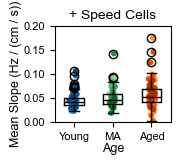

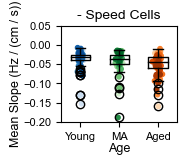

In [16]:
''' Plot Figure 6d '''

#set up handles
from itertools import repeat
handles = []
mper = [mper1[y_ind], mper1[ma_ind], mper1[age_ind]]

for i in range(len(mper)):    
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))
               
#Plot Figure 6d (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope99[y_sind99], sslope99[ma_sind99], sslope99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
plt.savefig(save_folder + '6Dleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Dleft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure 6d (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope1[y_sind1], sslope1[ma_sind1], sslope1[age_sind1]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session1[i], edgecolors = col_session1[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.2,0.05])
ax.set_yticks([-0.2,-0.15,-0.1,-0.05,0, 0.05])
plt.savefig(save_folder + '6Dright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Dright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [20]:
''' Statistics for Figure 6d (left) '''
print('\nn young, MA, sessions with + speed cells:')
print(len(y_sind99),len(ma_sind99), len(age_sind99))

print('\nspeedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope99[ma_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[ma_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[age_sind99]), 4)))

stat, p_diff = stats.kruskal(sslope99[y_sind99],sslope99[ma_sind99],sslope99[age_sind99])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#get what you need for multiple comparisons
import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind99,ma_sind99,age_sind99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopepos = list(sslope99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopepos', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, sessions with + speed cells:
96 58 96

speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
0.0445 ± 0.0015 ; 0.0508 ± 0.0027 ; 0.0556 ± 0.0026
stat = 15.152660049457381
p_session = 0.0005124384125900913


,1.0,2.0,3.0
1.0,1.000000,0.111112,0.000256
2.0,0.111112,1.000000,0.123937
3.0,0.000256,0.123937,1.000000


In [25]:
''' Statistics for Figure 6d (right) '''
print('\nn young, MA, sessions with - speed cells:')
print(len(y_sind1),len(ma_sind1), len(age_sind1))

print('speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope1[y_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[y_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope1[ma_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[ma_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope1[age_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[age_sind1]), 4)))

stat, p_diff = stats.kruskal(sslope1[y_sind1],sslope1[ma_sind1],sslope1[age_sind1])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind1,ma_sind1,age_sind1))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope1[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg',])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopeneg', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, sessions with - speed cells:
96 58 94
speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
-0.0366 ± 0.0024 ; -0.0432 ± 0.004 ; -0.05 ± 0.0026
stat = 24.32554182335332
p_session = 5.221264668905101e-06


,1.0,2.0,3.0
1.0,1.000000,0.081584,0.000002
2.0,0.081584,1.000000,0.013550
3.0,0.000002,0.013550,1.000000


In [21]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Speed Cell'''

import statsmodels.api as sm
import statsmodels.formula.api as smf

mice = all_mice
sessions = all_sessions

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
seshcount = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
                
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        speedcell99 = d['speedcell99']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
  
        for j, c in enumerate(speedcells99):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort,cohort)
            
            totalcells += 1
            
        seshcount += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Slope     
No. Observations:      11528       Method:                 ML        
No. Groups:            45          Scale:                  0.0012    
Min. group size:       38          Log-Likelihood:         16502.2620
Max. group size:       553         Converged:              Yes       
Mean group size:       256.2                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.039    0.005  7.714 0.000  0.029  0.049
C(AgeGroup)[T.2.0]          0.014    0.007  2.051 0.040  0.001  0.028
C(AgeGroup)[T.3.0]          0.017    0.005  3.705 0.000  0.008  0.027
C(Sex)[T.M]                 0.010    0.007  1.487 0.137 -0.003  0.024
C(Cohort)[T.B]             -0.007   

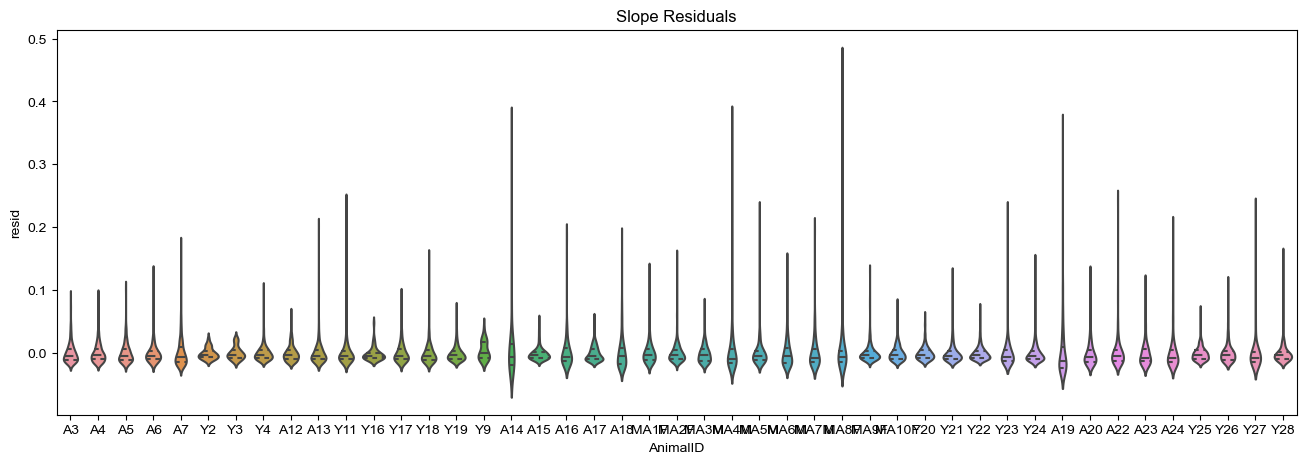

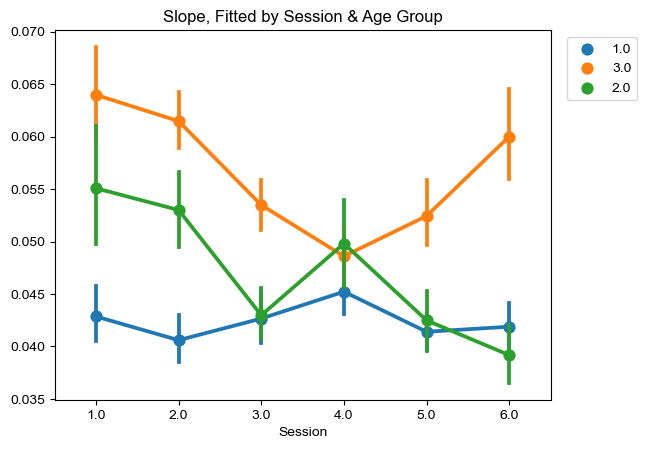

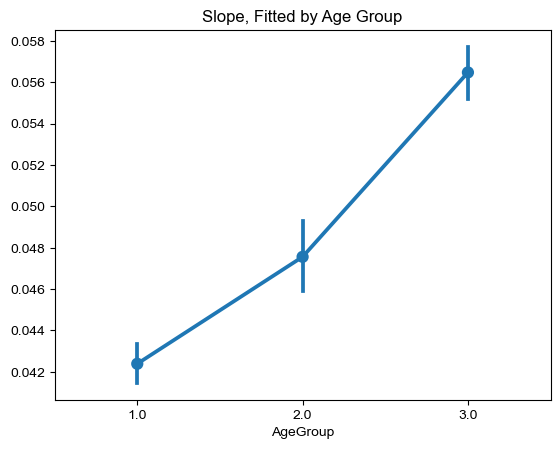

Raw Data Mean across All Sessions by Animal:
AnimalID
A12      0.044469
A13      0.045465
A14      0.097417
A15      0.034248
A16      0.055522
A17      0.036100
A18      0.075760
A19      0.088640
A20      0.056601
A22      0.052628
A23      0.058463
A24      0.062370
A3       0.049637
A4       0.051683
A5       0.051350
A6       0.048797
A7       0.064646
MA10F    0.037952
MA1F     0.051591
MA2F     0.042156
MA3M     0.049193
MA4M     0.062847
MA5M     0.045962
MA6M     0.064746
MA7M     0.059545
MA8F     0.061861
MA9F     0.033812
Y11      0.048747
Y16      0.030471
Y17      0.051531
Y18      0.049818
Y19      0.041227
Y2       0.035033
Y20      0.037560
Y21      0.038546
Y22      0.033665
Y23      0.047901
Y24      0.037213
Y25      0.040058
Y26      0.042146
Y27      0.054723
Y28      0.040462
Y3       0.041767
Y4       0.039465
Y9       0.068636

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12      0.044933
A13      0.045877
A14      0.093419
A15      0.034949
A16   

In [68]:
''' Run LMM on Speed Gain, Report out Fitted Values for Figure 7 & 8 '''

#gather dependent variables into lists
Slope = list(allslope99)

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Slope))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'AgeGroup','Cohort','Slope'])

#handle NaNs
df = df.dropna()

# Slope  Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mslope = smf.mixedlm('Slope ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = False)
print(mslope.summary())
print(mslope.wald_test_terms(scalar = False))
print(mslope.aic)
print(mslope.bic)

#plots of residuals
df['resid'] = mslope.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Slope Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mslope.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Slope, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mslope.fittedvalues)
plt.title('Slope, Fitted by Age Group')
plt.show()

df['fitted'] = mslope.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Slope'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')
#print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

In [18]:
''' Collect Speed Cell Trial Stability Score 

Run time: 10-15 seconds / session x 250 sessions with either type of speed cell.

'''
# set up arrays for plotting by session 
strialstabscore1 = []
strialstabscore99 = []
alltrialstabscore99 = []

dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in session:
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(save_folder + A_file)
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
        
        #get spike-weighted average of speed score by trial for each speed cell population
        bytrialspeedstabilityscores99 = []          
        for i, c in enumerate(speedcells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            bytrialspeedstabilityscores99 = np.append(bytrialspeedstabilityscores99, np.nansum(weightscore) / np.sum(A[:,sdx]))
            
        bytrialspeedstabilityscores1 = []
        for i, c in enumerate(speedcells1):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))
        
            bytrialspeedstabilityscores1 = np.append(bytrialspeedstabilityscores1, np.nansum(weightscore) / np.sum(A[:,sdx]))

        #Print Source Data for Figure 6e
        #print(str(m) + ',' + str(s[-1]) + ',' + str(np.mean(bytrialspeedstabilityscores99)) + ',' + str(np.mean(bytrialspeedstabilityscores1)))

        if m in np.union1d(cohortc_mice, cohortd_mice):
            print(str(m) + ',' + str(s[-1]) + ',' + str(np.mean(bytrialspeedstabilityscores99)))
            
        strialstabscore99 = np.append(strialstabscore99, np.mean(bytrialspeedstabilityscores99))
        strialstabscore1 = np.append(strialstabscore1, np.mean(bytrialspeedstabilityscores1))
        alltrialstabscore99 = np.append(alltrialstabscore99, bytrialspeedstabilityscores99)

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


A14,1,0.10931451228774704
A14,2,0.0767099274390175
A14,3,0.10194318148812835
A15,1,0.17311821533894783
A15,2,0.1713747272014333
A15,3,0.16539716052126627
A15,4,0.18708795154144875
A15,5,0.1764184128141737
A15,6,0.23545985503075437
A16,1,0.2059808659634382
A16,2,0.1459562667968244
A16,3,nan
A16,4,0.1726338501748698
A17,1,0.1512877877863622
A17,2,0.06508420062983983
A17,3,0.1578202278733592
A17,4,0.15995841103403707
A17,5,0.13522313000339972
A17,6,0.19485350213288832
A18,l,0.12305255868923745
A18,2,0.10914461747572882
A18,3,0.1668914233628339
A18,4,0.19673747741159678
A18,5,0.12033798065545043
A18,6,0.17066199658904652
MA1F,1,0.09759613620172151
MA1F,2,0.24634972634017638
MA1F,3,0.20615781746986403
MA1F,4,0.1704503263245664
MA1F,5,0.16548300237347033
MA1F,6,0.21741984424778205
MA2F,1,0.21892735190058782
MA2F,2,0.18972598856413322
MA2F,3,0.20868691651724794
MA2F,4,0.21782752381910658
MA2F,5,0.18776028253006788
MA2F,6,0.22286331343654273
MA3M,1,0.2594985381523374
MA3M,2,0.24817057853305338

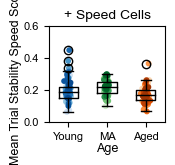

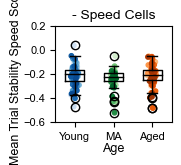

In [27]:
''' Plot Figure 6E '''

#Figure 6E (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore99[y_sind99], strialstabscore99[ma_sind99], strialstabscore99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.6])
ax.set_yticks([0,0.2,0.4,0.6])
plt.savefig(save_folder + '6Eleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Eleft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Figure 6E (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore1[y_sind1], strialstabscore1[ma_sind1], strialstabscore1[age_sind1]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session1[i], edgecolors = col_session1[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.6,0.2])
ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2])
plt.savefig(save_folder + '6Eright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Eright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [28]:
''' Stats for Figure 6e (left)'''

print('\nPOS SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore99[ma_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[ma_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[age_sind99]), 4)))

stat, p_diff = stats.kruskal(strialstabscore99[y_sind99],strialstabscore99[ma_sind99],strialstabscore99[age_sind99])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#POSTIVE
#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)
        
allidx = np.concatenate((y_sind99,ma_sind99,age_sind99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scorepos = list(strialstabscore99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scorepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scorepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scorepos', group_col = 'AgeGroup', p_adjust = 'holm')



POS SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
0.1905 ± 0.0063 ; 0.2143 ± 0.0061 ; 0.1693 ± 0.0047
stat = 29.4836321610112
p_trialstabscore = 3.960140761439548e-07


,1.0,2.0,3.0
1.0,1.000000,7.961169e-04,1.308860e-02
2.0,0.000796,1.000000e+00,7.481447e-08
3.0,0.013089,7.481447e-08,1.000000e+00


In [29]:
''' Stats for Figure 6e (right)'''

print('\nNEG SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore1[y_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[y_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore1[ma_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[ma_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore1[age_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[age_sind1]), 4)))

stat, p_diff = stats.kruskal(strialstabscore1[y_sind1],strialstabscore1[ma_sind1],strialstabscore1[age_sind1])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind1,ma_sind1,age_sind1))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore1[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scoreneg'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scoreneg', group_col = 'AgeGroup', p_adjust = 'holm')


NEG SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
-0.2125 ± 0.0081 ; -0.2393 ± 0.0098 ; -0.2165 ± 0.0082
stat = 6.4131184926557125
p_trialstabscore = 0.040495709598212117


,1.0,2.0,3.0
1.0,1.000000,0.040830,0.592191
2.0,0.040830,1.000000,0.091193
3.0,0.592191,0.091193,1.000000


C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Score    
No. Observations:       11528       Method:                 REML     
No. Groups:             45          Scale:                  0.0046   
Min. group size:        38          Log-Likelihood:         9073.6018
Max. group size:        553         Converged:              Yes      
Mean group size:        256.2                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.148    0.014 10.384 0.000  0.120  0.176
C(AgeGroup)[T.2.0]          0.012    0.020  0.589 0.556 -0.027  0.050
C(AgeGroup)[T.3.0]          0.005    0.013  0.401 0.689 -0.020  0.030
C(Sex)[T.M]                -0.009    0.021 -0.438 0.662 -0.050  0.032
C(Cohort)[T.B]              0.010   

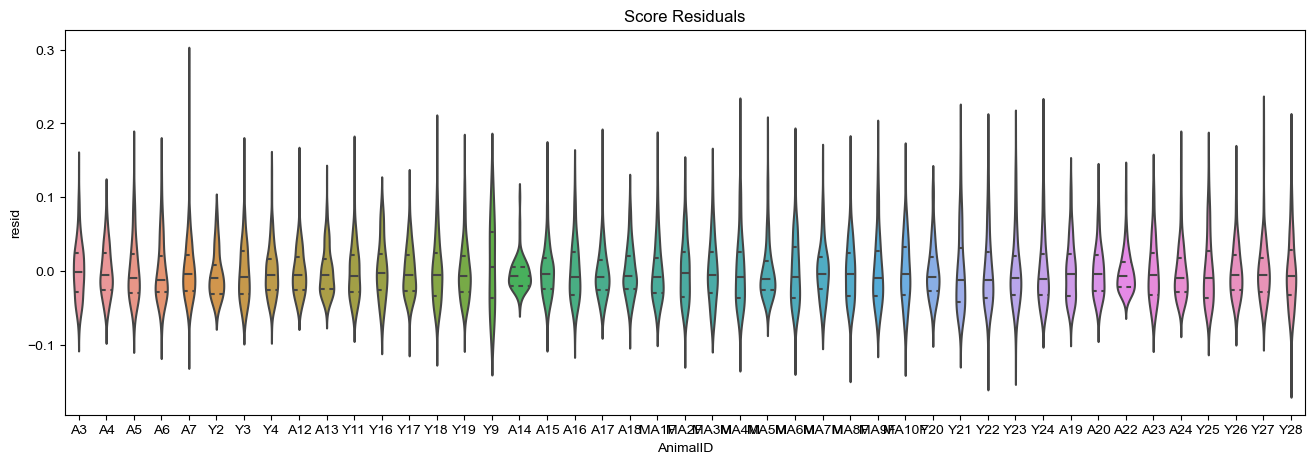

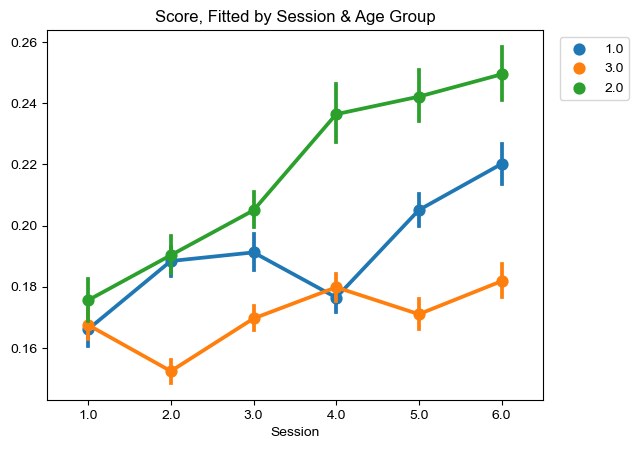

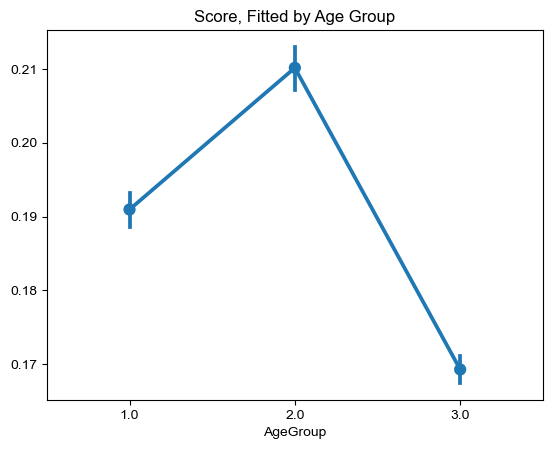

Raw Data Mean across All Sessions by Animal:
AnimalID
A12      0.152093
A13      0.143345
A14      0.089023
A15      0.183843
A16      0.176114
A17      0.157220
A18      0.144348
A19      0.180845
A20      0.182407
A22      0.128672
A23      0.196348
A24      0.171107
A3       0.226238
A4       0.175198
A5       0.198792
A6       0.169294
A7       0.164124
MA10F    0.246420
MA1F     0.195481
MA2F     0.209108
MA3M     0.239460
MA4M     0.221449
MA5M     0.159936
MA6M     0.198913
MA7M     0.193963
MA8F     0.206272
MA9F     0.218882
Y11      0.182941
Y16      0.197186
Y17      0.153511
Y18      0.167977
Y19      0.162199
Y2       0.107489
Y20      0.189956
Y21      0.231121
Y22      0.206308
Y23      0.210609
Y24      0.191258
Y25      0.222490
Y26      0.177589
Y27      0.191231
Y28      0.216557
Y3       0.140097
Y4       0.160670
Y9       0.279712

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12      0.152241
A13      0.143629
A14      0.092718
A15      0.183614
A16   

In [67]:
''' Run LMM on Speed Tuning Stability across Trials, Report out Fitted Values for Figure 7 & 8 '''

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)
Score = list(alltrialstabscore99)

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Score))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'AgeGroup','Cohort','Score'])

#handle NaNs
df = df.dropna()

# Score  Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mscore = smf.mixedlm('Score ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = True)
print(mscore.summary())
print(mscore.wald_test_terms(scalar = False))
#print(mscore.aic)
#print(mscore.bic)

#plots of residuals
df['resid'] = mscore.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Score Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mscore.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Score, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mscore.fittedvalues)
plt.title('Score, Fitted by Age Group')
plt.show()

df['fitted'] = mscore.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Score'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# Sig. session x age effects... Therefore, reporting change in mean across sessions
print('\nFitted Data Mean across All Sessions by Animal:')
print('First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
print('Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

# Sig. session x age effects... Therefore, reporting change in mean across sessions
print('\nFitted Data Mean across All Sessions by Animal:')
print('First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['Score'].mean().to_string(index = True))
print('Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['Score'].mean().to_string(index = True))

## For Split Maze Sessions: Examine Block & Alt Speed Gain & Tuning Stability Separately

In [14]:
''' Load indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded.

Generated in Extended Data Fig. 2 notebook. Please run that before proceeding.

''' 

figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Extended Data Fig. 2 notebook save_folder

for m, session in zip(mice,sessions):
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        for s in session:
            d = data[m][s]

            #save indices for session sections
            Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
            Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
            A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
            B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
            A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
            B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'

            Aidx = np.load(figs2_folder + Aidx_file)
            Bidx = np.load(figs2_folder + Bidx_file)
            A_idx = np.load(figs2_folder + A_idx_file)
            B_idx = np.load(figs2_folder + B_idx_file)

            d['Aidx'] = Aidx
            d['Bidx'] = Bidx
            d['A_idx'] = A_idx
            d['B_idx'] = B_idx

            #Also load A`& B` indices excluding gain change trials in each context
            A_ngidx = np.load(figs2_folder + A_ngidx_file)
            B_ngidx = np.load(figs2_folder + B_ngidx_file)

            d['A_ngidx'] = A_ngidx
            d['B_ngidx'] = B_ngidx

In [15]:
''' Total of Cells of Each Type by Age Group at P99 Thresholds'''

ypos = 0
mapos = 0
apos = 0

yneg = 0
maneg = 0
aneg = 0 

for m, session in zip(mice,sessions):   
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        for s in session:

            d = data[m][s]

            #load in data
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')

            poscell = d['speedcell99']
            negcell = d['speedcell1']

            poscell = poscell.astype(bool)
            negcell = negcell.astype(bool)

            if (m in all_aged_mice):
                apos += np.sum(poscell)
                aneg += np.sum(negcell)
            elif m in SM_MA_mice:
                mapos += np.sum(poscell)
                maneg += np.sum(negcell)
            else:
                ypos += np.sum(poscell)
                yneg += np.sum(negcell)
            
print(ypos, mapos, apos)
print(yneg, maneg, aneg)

3933 4062 3423
1472 2071 1415


In [16]:
''' Collect Speed Cell FR Slope in Block & Alt Separately for SM Mice Only '''
# set up arrays for plotting by session 
sslope99block = []
sslope99alt = []
sslope1block = []
sslope1alt = []

#array for LMM
allslope99block = []
allslope99alt = []
allslope1block = []
allslope1alt = []

dt = 0.02

sper99 = []
sper1 = []
mper99 = []
mper1 = []

for m, session in zip(mice,sessions):
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        m_cells = []
        m_99 = []
        m_1 = []
    
        for s in tdqm(session):
            d = data[m][s]

            #get file names & load data necessary
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
            A_file = 'A_' + m + '_' + s + '.npy'
            intn_file = 'intn_' + m + '_' + s + '.npy'
            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            A = np.load(save_folder + A_file)
            speed = behaviorfil[:,1]
            trial = behaviorfil[:,2]

            #get dict-stored data
            cell_IDs = raw.item().get('cellsfil')
            d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
            intn = d['intn'].astype(bool)
            speedcell99 = d['speedcell99']
            speedcell1 = d['speedcell1']
            speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
            speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]

            sper99 = np.append(sper99, 100*len(speedcells99)/len(cell_IDs))
            sper1 = np.append(sper1, 100*len(speedcells1)/len(cell_IDs))
            
            #load the context lengths, exclude A' and B' gain change trials
            Aidx = d['Aidx']
            Bidx = d['Bidx'] 
            A_idx = d['A_idx']
            B_idx = d['B_idx'] 
                          
            blockind = np.union1d(Aidx,Bidx)
            altind = np.union1d(A_idx, B_idx)

            #get slopes for each speed cell population in both task phases, excluding dark period
            bslope99 = []
            aslope99 = []
            for i, c in enumerate(speedcells99):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                #get slope/FR on block trials and convert to Hz/speed
                bslopeFR, bintFR, r_value, p_val, std_err = stats.linregress(speed[blockind], A[blockind,sdx])
                bslopeFR = bslopeFR/dt
                bintFR = bintFR/dt
                bslope99 = np.append(bslope99,bslopeFR) #FR/speed slope
                
                #get slope/FR on alt trials and convert to Hz/speed
                aslopeFR, aintFR, r_value, p_val, std_err = stats.linregress(speed[altind], A[altind,sdx])
                aslopeFR = aslopeFR/dt
                aintFR = aintFR/dt
                aslope99 = np.append(aslope99,aslopeFR) #FR/speed slope

            bslope1 = []
            aslope1 = []
            for i, c in enumerate(speedcells1):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                #get slope/FR on block trials and convert to Hz/speed
                bslopeFR, bintFR, r_value, p_val, std_err = stats.linregress(speed[blockind], A[blockind,sdx])
                bslopeFR = bslopeFR/dt
                bintFR = bintFR/dt
                bslope1 = np.append(bslope1,bslopeFR) #FR/speed slope
                
                #get slope/FR on alt trials and convert to Hz/speed
                aslopeFR, aintFR, r_value, p_val, std_err = stats.linregress(speed[altind], A[altind,sdx])
                aslopeFR = aslopeFR/dt
                aintFR = aintFR/dt
                aslope1 = np.append(aslope1,aslopeFR) #FR/speed slope

            #pool data into session arrays    
            sslope99block = np.append(sslope99block, np.mean(bslope99))
            sslope99alt = np.append(sslope99alt, np.mean(aslope99))
            sslope1block = np.append(sslope1block, np.mean(bslope1))
            sslope1alt = np.append(sslope1alt, np.mean(aslope1))
            
            m_cells = np.append(m_cells, len(cell_IDs))
            m_99 = np.append(m_99, len(speedcells99))
            m_1 = np.append(m_1, len(speedcells1))
            
            allslope99block = np.append(allslope99block,bslope99)
            allslope99alt = np.append(allslope99alt,aslope99)
            allslope1block = np.append(allslope1block,bslope1)
            allslope1alt = np.append(allslope1alt,aslope1)

        mper99 = np.append(mper99, 100*np.sum(m_99)/np.sum(m_cells))
        mper1 = np.append(mper1, 100*np.sum(m_1)/np.sum(m_cells))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Pos Speed Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):
    
        msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
        age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
        cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
        totalsesh = len(session)

        for i, s in enumerate(tdqm(session)):

            d = data[m][s]

            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            intn_file = 'intn_' + m + '_' + s + '.npy'
            
            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')
            d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
            intn = d['intn'].astype(bool)
            speedcell99 = d['speedcell99']
            speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]

            for j, c in enumerate(speedcells99):
                cidx = np.append(cidx, totalcells)
                csex = np.append(csex, msex)
                cmice = np.append(cmice, m)
                ccount = np.append(ccount, (i + 1))
                cage = np.append(cage, age)
                ccohort = np.append(ccohort, cohort)

                totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    SlopeBlock
No. Observations:      7464       Method:                REML      
No. Groups:            29         Scale:                 0.0014    
Min. group size:       79         Log-Likelihood:        9816.4543 
Max. group size:       479        Converged:             Yes       
Mean group size:       257.4                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.040    0.004  8.968 0.000  0.032  0.049
C(AgeGroup)[T.2.0]        0.019    0.007  2.809 0.005  0.006  0.032
C(AgeGroup)[T.3.0]        0.021    0.006  3.424 0.001  0.009  0.032
C(Sex)[T.M]               0.007    0.006  1.197 0.231 -0.005  0.019
C(Cohort)[T.D]            0.004    0.008  0.513 0.608 -0.011  0

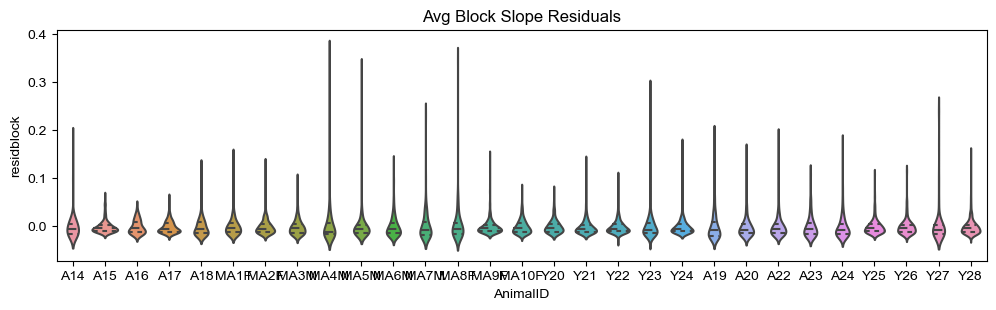

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    SlopeAlt  
No. Observations:      7464       Method:                REML      
No. Groups:            29         Scale:                 0.0011    
Min. group size:       79         Log-Likelihood:        10809.7906
Max. group size:       479        Converged:             Yes       
Mean group size:       257.4                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.028    0.004  6.997 0.000  0.020  0.035
C(AgeGroup)[T.2.0]        0.015    0.006  2.523 0.012  0.003  0.027
C(AgeGroup)[T.3.0]        0.027    0.005  5.148 0.000  0.017  0.037
C(Sex)[T.M]               0.013    0.005  2.360 0.018  0.002  0.023
C(Cohort)[T.D]           -0.005    0.007 -0.709 0.478 -0.018  0

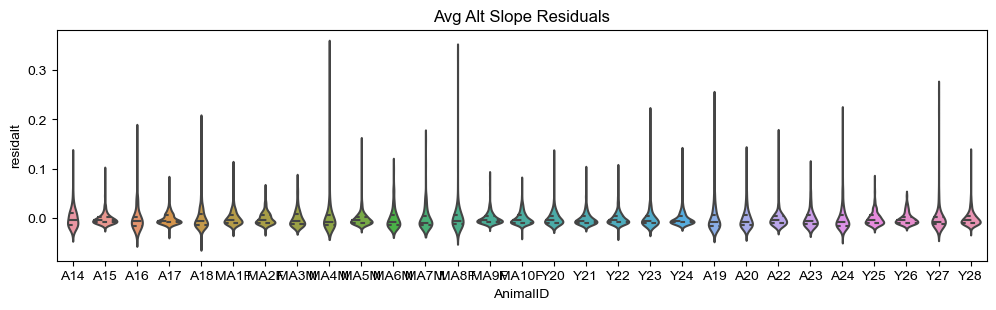

In [18]:
''' LMMs for Pos Speed Cell Slope '''        
#gather dependent variables into lists
Slope99Block = allslope99block
Slope99Alt = allslope99alt
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Slope99Block, Slope99Alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','SlopeBlock','SlopeAlt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('SlopeBlock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Slope Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('SlopeAlt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
#print(malt.aic)
#print(malt.bic)

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt Slope Residuals')
plt.show()

#Collect Fig 6 Source Data
#df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure6\6x.csv', index = False, header = True)

In [19]:
''' Get fitted block vs. alternation pos speed cell slope session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

sslopeAfitted_seg_aged = [[] * r for i in range(r)]
sslopeAfitted_seg_MA = [[] * r for i in range(r)]
sslopeAfitted_seg_young = [[] * r for i in range(r)]
sslopeBfitted_seg_aged = [[] * r for i in range(r)]
sslopeBfitted_seg_MA = [[] * r for i in range(r)]
sslopeBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        animalidx = np.where(seshAanimal == m)[0][0]
        sessiona_idx = np.where(seshAanimal == m)[0]
        sessionb_idx = np.where(seshBanimal == m)[0]

        if m in SM_aged_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sslopeAfitted_seg_aged[idx] = np.append(sslopeAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1 
                sslopeBfitted_seg_aged[idx] = np.append(sslopeBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    

        elif m in SM_MA_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sslopeAfitted_seg_MA[idx] = np.append(sslopeAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sslopeBfitted_seg_MA[idx] = np.append(sslopeBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
        else:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sslopeAfitted_seg_young[idx] = np.append(sslopeAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sslopeBfitted_seg_young[idx] = np.append(sslopeBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


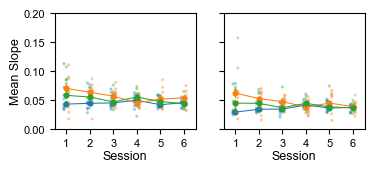

In [20]:
''' Composite Plot of Alternation Speed Slope w/ Fitted Session Average Data Points'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.05,0.10,0.15,0.20])
ax[0].set_ylim([0.0,0.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Slope', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(sslopeAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, sslopeAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], sslopeAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, sslopeAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, sslopeBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], sslopeBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, sslopeBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'posslopesesh.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'posslopesesh.svg', dpi=400, bbox_inches='tight')
plt.show()

In [21]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

SMmice = np.union1d(cohortc_mice,cohortd_mice)


s_count = 0
for m, s in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        start = s_count
        end = len(s) + s_count

        if m in all_aged_mice:
            age_ind = np.append(age_ind, (np.where(SMmice == m)[0]))
            age_sind = np.append(age_sind, np.arange(start, end, 1))
        elif m in all_MA_mice:
            ma_ind = np.append(ma_ind, (np.where(SMmice == m)[0]))
            ma_sind = np.append(ma_sind, np.arange(start, end, 1))
        else:
            y_ind = np.append(y_ind, (np.where(SMmice == m)[0]))
            y_sind = np.append(y_sind, np.arange(start, end, 1))

        s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['A18' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F'] ['Y16' 'Y17' 'Y18' 'Y19' 'Y9' 'A14' 'A15' 'A16' 'A17' 'Y11'] ['A3' 'A4' 'A5' 'A6' 'A7' 'Y2' 'Y3' 'Y4' 'A12' 'A13']
9 10 10
54 58 55


In [22]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

SMmice = np.union1d(cohortc_mice,cohortd_mice)

for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):

        for s in range(0,len(session)):

            if m in SM_aged_mice:
                idx = np.where(SMmice == m)[0] 
                col_session_old.append(col_animal[2][0][idx])           
            elif m in SM_MA_mice:
                idx = np.where(SMmice == m)[0] - Nold
                col_session_MA.append(col_animal[1][0][idx])
            else:
                idx = np.where(SMmice == m)[0] - (Nold + Nma)
                col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mper99[y_ind], mper99[ma_ind], mper99[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

In [23]:
''' Find where I will have NaNs'''
nan_idx99 = np.where((sper99 == 0))[0]
nan_idx1 = np.where((sper1 == 0))[0]
print(nan_idx99, nan_idx1)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
ma_sind99 = np.setdiff1d(ma_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

y_sind1 = np.setdiff1d(y_sind, nan_idx1)
ma_sind1 = np.setdiff1d(ma_sind, nan_idx1)
age_sind1 = np.setdiff1d(age_sind, nan_idx1)

# Adjust colormaps for 99 plots
yidx = []
maidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_young99 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma99 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session99 = [col_session_young99, col_session_ma99, col_session_old99] 

# Adjust colormaps for 1 plots
yidx = []
maidx = []
aidx = []
for i in nan_idx1:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_young1 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma1 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old1 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session1 = [col_session_young1, col_session_ma1, col_session_old1] 

print(len(col_session_young99),len(col_session_young1))
print(len(col_session_ma99),len(col_session_ma1))
print(len(col_session_old99),len(col_session_old1))

# This will fix session stats & box plots are plotted.

[11] [  3  19 143]
54 58 55
54 53
58 58
54 53


In [24]:
''' Get reward & lick data for sessions w/ neural data'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
        
        for s in session:
            d = data[m][s]

            #load data
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            d['reward_data'] = {}

            # get behavioral params
            posx = raw.item().get('posx')
            post = raw.item().get('post')
            dt = np.unique(np.round(np.diff(post),4))
            lickt = raw.item().get('lickt')
            trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
            reward = raw.item().get('reward')
            reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 

            if len(dt) > 1: # discard duplicate frame entries if they occurred
                dt = dt[dt != 0]
            speed = raw.item().get('speed')

            # get reward params & remove reward data pertaining to dark trials & skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = 220)
                nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
                k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
                keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)

            except:
                skippedtrials = []
                trial = raw.item().get('trial')
                keep_idx = (np.where(reward['trials'] > trials_dark))

            reward_centers = np.array(reward['centers'][keep_idx])
            rewardt = reward['times'][keep_idx]
            reward_trials = reward['trials'][keep_idx]
            misses = reward['missed'][keep_idx].astype(bool)
            auto_reward = np.array(reward['auto'][keep_idx])
            #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

            # get lick and reward indices
            lick_ct = get.spiketrain(post, dt, lickt, index=False)
            d['reward_data']['lick_ct'] = lick_ct
            #print('got lick indices for mouse ' + m + ' session ' + s)

            reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
            d['reward_data']['reward_idx'] = reward_idx
            #print('got reward indices for mouse ' + m + ' session ' + s)

        # saves list of reward locations per mouse
        if reward['centers'][0] == 270:
            rewarda_centers = np.append(rewarda_centers,270)
            rewardb_centers = np.append(rewardb_centers,370)
        else:
            rewarda_centers = np.append(rewarda_centers,370)
            rewardb_centers = np.append(rewardb_centers,270)            

In [25]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):
    
        rt = []
        ca = []
        cb = []
        blocks = []
        alt = []
        alta = []
        altb = []

        req = []
        reqa = []
        reqb = []
        reqblocks = []
        reqalt = []
        reqalta = []
        reqaltb = []

        for s in session:
            # get behavior data
            d = data[m][s]

            #load data
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            posx = raw.item().get('posx')
            post = raw.item().get('post')
            dt = np.unique(np.round(np.diff(post),4))
            if len(dt) > 1: # discard duplicate frame entries if they occurred
                dt = dt[dt != 0]
            speed = raw.item().get('speed')

            # get reward params & remove reward data pertaining to dark trials & skipped trials
            lickt = raw.item().get('lickt')
            trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
            reward = raw.item().get('reward')
            reward['trials'] = np.arange(0,len(reward['trials']),1)

            # get reward params & remove reward data pertaining to dark trials & skipped trials
            try:
                _ = raw.item().get('correctedtrial').shape
                skippedtrials = get.find_skipped(trial, max_trial_num = 220)
                nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
                k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
                keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)

            except:
                skippedtrials = []
                trial = raw.item().get('trial')
                keep_idx = (np.where(reward['trials'] > trials_dark))

            reward_centers = np.array(reward['centers'][keep_idx])
            rewarda = reward_centers[0]
            rewardb = reward_centers[60]
            rewardt = reward['times'][keep_idx]
            reward_trials = reward['trials'][keep_idx]
            misses = reward['missed'][keep_idx].astype(bool)
            requests = ~misses

            # find rate of requests for a given session
            req_rates.append(np.sum(requests)/len(reward_trials)) #total

            rewarda_idx = np.where(reward_trials < 81)[0]
            reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a

            rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
            reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b

            block_idx = np.where(reward_trials < 140)[0]
            reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block

            alt_idx = np.where(reward_trials >= 140)[0]
            reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt

            alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
            reqalta_rates.append(np.mean(requests[alta_idx]))

            altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
            reqaltb_rates.append(np.mean(requests[altb_idx]))

            rt = np.append(rt,len(reward_trials))
            ca = np.append(ca,len(rewarda_idx))
            cb = np.append(cb,len(rewardb_idx))
            blocks = np.append(blocks,len(block_idx))
            alt = np.append(alt,len(alt_idx))
            alta = np.append(alta, len(alta_idx))
            altb = np.append(altb, len(altb_idx))

            req_trials = np.append(req_trials, len(reward_trials))
            reqblock_trials = np.append(reqblock_trials, len(block_idx))
            reqalt_trials = np.append(reqalt_trials, len(alt_idx))

            req = np.append(req,np.sum(requests))
            reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
            reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
            reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
            reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
            reqalta = np.append(reqalta,requests[alta_idx])
            reqaltb = np.append(reqaltb,requests[altb_idx])

            d['altreqbytrial'] = requests[alt_idx]

        # get mouse request rate collapsing days
        mreqrate = np.sum(req)/ np.sum(rt)
        mreq_rates = np.append(mreq_rates,mreqrate)

        mreqarate = np.sum(reqa) / np.sum(ca)
        mreqa_rates = np.append(mreqa_rates, mreqarate)

        mreqbrate = np.sum(reqb) / np.sum(cb)
        mreqb_rates = np.append(mreqb_rates, mreqbrate)

        mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
        mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)

        mreqaltrate = np.sum(reqalt) / np.sum(alt)
        mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)

        mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
        mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.15254203937065813 -0.04201119823737643 -0.03079977083905064 -0.0751176885837087
P [Young, MA, Aged, All]: 
0.27081781171678426 0.7541886089929701 0.8250241659438992 0.3361147614711535

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.0047599004096115375 -0.11181523513673933 0.07885002896401767 -0.07070945931042479
P [Young, MA, Aged, All]: 
0.9727497944621052 0.40335345654100196 0.5708822158394389 0.36531845412885455

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.10954695992248534 0.06802346981688495 0.0995407174444458 0.047674509782325986
P [Young, MA, Aged, All]: 
0.2590671683056139 0.4681195954734121 0.30537802405401654 0.3865520834747289

n session halves: young, ma, aged
108 116 108


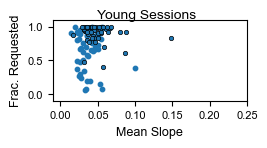

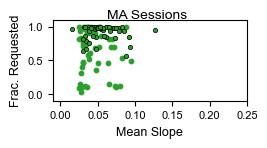

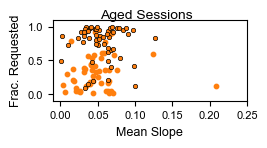

In [103]:
''' Plot Figure 6X with Block & Alt. Data '''
allidx = np.concatenate((y_sind99, ma_sind99, age_sind99))

#Linear regression with block data only
res = stats.linregress(sslope99block[y_sind99],reqblock_rates[y_sind99])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sslope99block[ma_sind99],reqblock_rates[ma_sind99])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sslope99block[age_sind99],reqblock_rates[age_sind99])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sslope99block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sslope99alt[y_sind99],reqalt_rates[y_sind99])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sslope99alt[ma_sind99],reqalt_rates[ma_sind99])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sslope99alt[age_sind99],reqalt_rates[age_sind99])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sslope99alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sslope99block[y_sind99],sslope99alt[y_sind99])),np.hstack((reqblock_rates[y_sind99],reqalt_rates[y_sind99])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sslope99block[ma_sind99],sslope99alt[ma_sind99])),np.hstack((reqblock_rates[ma_sind99],reqalt_rates[ma_sind99])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sslope99block[age_sind99],sslope99alt[age_sind99])),np.hstack((reqblock_rates[age_sind99],reqalt_rates[age_sind99])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sslope99block[allidx],sslope99alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sind99)*2,len(ma_sind99)*2,len(age_sind99)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sslope99alt[y_sind99],reqalt_rates[y_sind99], color = 'C0', s = 10)
ax.scatter(sslope99block[y_sind99],reqblock_rates[y_sind99], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Slope', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.01,0.25])
ax.set_xticks([0,0.05,0.10,0.15,0.2,0.25])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'posslopeleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'posslopeleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sslope99alt[ma_sind99],reqalt_rates[ma_sind99], color = 'C2', s = 10)
ax.scatter(sslope99block[ma_sind99],reqblock_rates[ma_sind99], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Slope', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.01,0.25])
ax.set_xticks([0,0.05,0.10,0.15,0.2,0.25])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'posslopemiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'posslopemiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sslope99alt[age_sind99],reqalt_rates[age_sind99], color = 'C1', s = 10)
ax.scatter(sslope99block[age_sind99],reqblock_rates[age_sind99], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Slope', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.01,0.25])
ax.set_xticks([0,0.05,0.10,0.15,0.2,0.25])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
#ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'possloperight.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'possloperight.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Figure 2h
#print(list(sslope99block))
#print(list(reqblock_rates))
#print(list(sslope99alt))
#print(list(reqalt_rates))

In [26]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Neg Speed Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):
    
        msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
        age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
        cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
        totalsesh = len(session)

        for i, s in enumerate(tdqm(session)):

            d = data[m][s]

            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            intn_file = 'intn_' + m + '_' + s + '.npy'
            
            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')
            d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
            intn = d['intn'].astype(bool)
            speedcell1 = d['speedcell1']
            speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]

            for j, c in enumerate(speedcells1):
                cidx = np.append(cidx, totalcells)
                csex = np.append(csex, msex)
                cmice = np.append(cmice, m)
                ccount = np.append(ccount, (i + 1))
                cage = np.append(cage, age)
                ccohort = np.append(ccohort, cohort)

                totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    SlopeBlock
No. Observations:      4098       Method:                REML      
No. Groups:            29         Scale:                 0.0010    
Min. group size:       36         Log-Likelihood:        6011.2745 
Max. group size:       321        Converged:             Yes       
Mean group size:       141.3                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.026    0.005 -5.547 0.000 -0.036 -0.017
C(AgeGroup)[T.2.0]       -0.017    0.007 -2.542 0.011 -0.031 -0.004
C(AgeGroup)[T.3.0]       -0.028    0.007 -4.325 0.000 -0.041 -0.015
C(Sex)[T.M]              -0.008    0.006 -1.349 0.177 -0.018  0.003
C(Cohort)[T.D]            0.007    0.007  0.992 0.321 -0.007  0

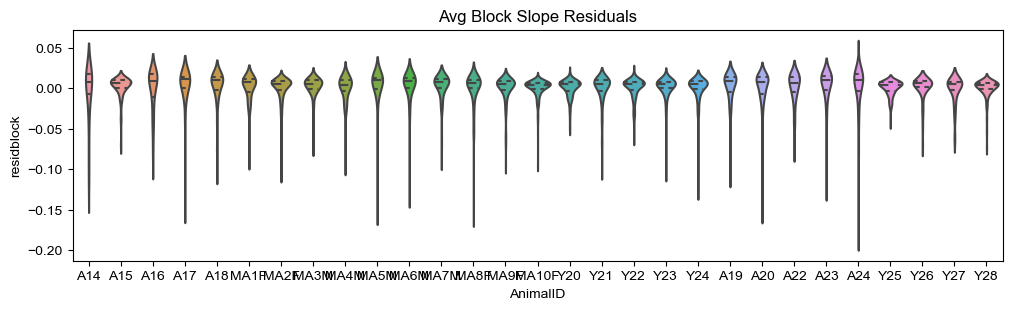

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     SlopeAlt 
No. Observations:     4098        Method:                 REML     
No. Groups:           29          Scale:                  0.0006   
Min. group size:      36          Log-Likelihood:         6093.4549
Max. group size:      321         Converged:              No       
Mean group size:      141.3                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.027    0.008 -3.166 0.002 -0.043 -0.010
C(AgeGroup)[T.2.0]       -0.010    0.013 -0.776 0.438 -0.035  0.015
C(AgeGroup)[T.3.0]       -0.015    0.011 -1.384 0.166 -0.035  0.006
C(Sex)[T.M]              -0.003    0.013 -0.274 0.784 -0.028  0.021
C(Cohort)[T.D]            0.003    0.016  0.182 0.855 -0.028  0

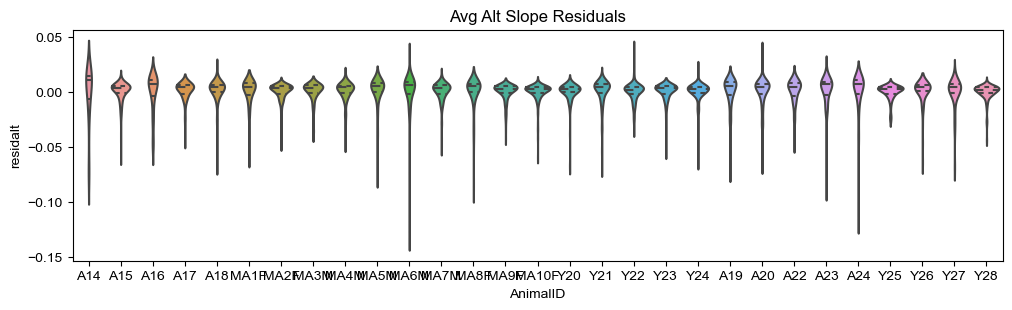

In [29]:
''' LMMs for Neg Speed Cell Slope '''        
#gather dependent variables into lists
Slope1Block = allslope1block
Slope1Alt = allslope1alt
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Slope1Block, Slope1Alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','SlopeBlock','SlopeAlt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('SlopeBlock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Slope Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('SlopeAlt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
#print(malt.aic)
#print(malt.bic)

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt Slope Residuals')
plt.show()

#Collect Fig 6 Source Data
#df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure6\6x.csv', index = False, header = True)

In [106]:
''' Get fitted block vs. alternation neg speed cell slope session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

sslopeAfitted_seg_aged = [[] * r for i in range(r)]
sslopeAfitted_seg_MA = [[] * r for i in range(r)]
sslopeAfitted_seg_young = [[] * r for i in range(r)]
sslopeBfitted_seg_aged = [[] * r for i in range(r)]
sslopeBfitted_seg_MA = [[] * r for i in range(r)]
sslopeBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        animalidx = np.where(seshAanimal == m)[0][0]
        sessiona_idx = np.where(seshAanimal == m)[0]
        sessionb_idx = np.where(seshBanimal == m)[0]

        if m in SM_aged_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sslopeAfitted_seg_aged[idx] = np.append(sslopeAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1 
                sslopeBfitted_seg_aged[idx] = np.append(sslopeBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    

        elif m in SM_MA_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sslopeAfitted_seg_MA[idx] = np.append(sslopeAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sslopeBfitted_seg_MA[idx] = np.append(sslopeBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
        else:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sslopeAfitted_seg_young[idx] = np.append(sslopeAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sslopeBfitted_seg_young[idx] = np.append(sslopeBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
8 10 8

n aged, MA, young mice on day 1 for B
8 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


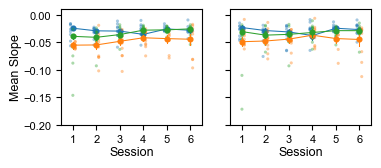

In [107]:
''' Composite Plot of Speed Slope w/ Fitted Session Average Data Points'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([-0.20,-0.15,-0.10,-0.05,0])
ax[0].set_ylim([-0.2,0.01])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Slope', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(sslopeAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, sslopeAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], sslopeAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, sslopeAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, sslopeBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], sslopeBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, sslopeBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'negslopesesh.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'negslopesesh.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.1013535702361079 0.2587840336853652 -0.0202307023158839 0.1768760777651045
P [Young, MA, Aged, All]: 
0.4702125370261444 0.04982162267178049 0.8856707118789312 0.02347050912450938

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.06327812898821193 0.25788595217432064 -0.22173816892112236 0.14439014121450552
P [Young, MA, Aged, All]: 
0.6526105869631211 0.05064865618955447 0.11055118860204396 0.06509121313371828

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.07482588239277878 0.2018322588723438 -0.18112426260452072 0.10712756414532322
P [Young, MA, Aged, All]: 
0.445872130151849 0.02980515972695571 0.06315803080834931 0.052582098058989404

n session halves: young, ma, aged
106 116 106


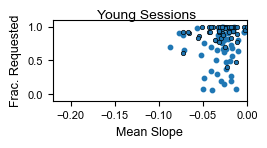

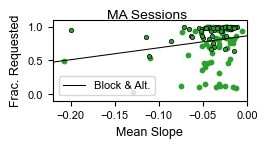

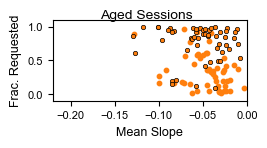

In [108]:
''' Plot Figure 6X with Block & Alt. Data '''
allidx = np.concatenate((y_sind1, ma_sind1, age_sind1))

#Linear regression with block data only
res = stats.linregress(sslope1block[y_sind1],reqblock_rates[y_sind1])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sslope1block[ma_sind1],reqblock_rates[ma_sind1])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sslope1block[age_sind1],reqblock_rates[age_sind1])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sslope1block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sslope1alt[y_sind1],reqalt_rates[y_sind1])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sslope1alt[ma_sind1],reqalt_rates[ma_sind1])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sslope1alt[age_sind1],reqalt_rates[age_sind1])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sslope1alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sslope1block[y_sind1],sslope1alt[y_sind1])),np.hstack((reqblock_rates[y_sind1],reqalt_rates[y_sind1])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sslope1block[ma_sind1],sslope1alt[ma_sind1])),np.hstack((reqblock_rates[ma_sind1],reqalt_rates[ma_sind1])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sslope1block[age_sind1],sslope1alt[age_sind1])),np.hstack((reqblock_rates[age_sind1],reqalt_rates[age_sind1])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sslope1block[allidx],sslope1alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sind1)*2,len(ma_sind1)*2,len(age_sind1)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sslope1alt[y_sind1],reqalt_rates[y_sind1], color = 'C0', s = 10)
ax.scatter(sslope1block[y_sind1],reqblock_rates[y_sind1], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Slope', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.22,0])
ax.set_xticks([-0.2,-0.15,-0.1,-0.05,0])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'negslopeleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'negslopeleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sslope1alt[ma_sind1],reqalt_rates[ma_sind1], color = 'C2', s = 10)
ax.scatter(sslope1block[ma_sind1],reqblock_rates[ma_sind1], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Slope', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.22,0])
ax.set_xticks([-0.2,-0.15,-0.1,-0.05,0])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'negslopemiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'negslopemiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sslope1alt[age_sind1],reqalt_rates[age_sind1], color = 'C1', s = 10)
ax.scatter(sslope1block[age_sind1],reqblock_rates[age_sind1], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Slope', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.22,0])
ax.set_xticks([-0.2,-0.15,-0.1,-0.05,0])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
#ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'negsloperight.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'negsloperight.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Figure 2h
#print(list(sslope1block))
#print(list(reqblock_rates))
#print(list(sslope1alt))
#print(list(reqalt_rates))

In [138]:
''' Collect Speed Cell Trial Stability Score for Block & Alt Phases (SM Mice Only)

Run time: 10-15 seconds / session x 167 sessions with either type of speed cell.

'''
# set up arrays for plotting by session 
sscoreblock1 = []
sscorealt1 = []
sscoreblock99 = []
sscorealt99 = []

allscoreblock99 = []
allscorealt99 = []
allscoreblock1 = []
allscorealt1 = []

dt = 0.02

for m, session in zip(mice,sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):

        for s in tdqm(session):
            d = data[m][s]

            #get file names & load data necessary
            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
            behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
            A_file = 'A_' + m + '_' + s + '.npy'

            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)

            A = np.load(save_folder + A_file)
            speed = behaviorfil[:,1]
            trial = behaviorfil[:,2]

            #get dict-stored data
            cell_IDs = raw.item().get('cellsfil')
            intn = d['intn'].astype(bool)
            speedcell99 = d['speedcell99']
            speedcell1 = d['speedcell1']
            speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]
            speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]
            
            #load the context lengths, exclude A' and B' gain change trials
            Aidx = d['Aidx']
            Bidx = d['Bidx'] 
            A_idx = d['A_idx']
            B_idx = d['B_idx'] 
                          
            blockind = np.union1d(Aidx,Bidx)
            altind = np.union1d(A_idx,B_idx)

            #get spike-weighted average of speed score by trial for each speed cell population
            blockscores99 = []  
            altscores99 = []
            for i, c in enumerate(speedcells99):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                #block phase
                weightscore = []
                for j, t in enumerate(np.unique(trial[blockind])):
                    trialidx = np.where(trial == t)[0].astype(int)

                    trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                    weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))  
                    
                if np.sum(A[blockind,sdx]) != 0:
                    blockscores99 = np.append(blockscores99, np.nansum(weightscore) / np.sum(A[blockind,sdx]))
                else:
                    blockscores99 = np.append(blockscores99, np.nan)

                #alt phase
                weightscore = []
                for j, t in enumerate(np.unique(trial[altind])):
                    trialidx = np.where(trial == t)[0].astype(int)

                    trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                    weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            
                if np.sum(A[altind,sdx]) != 0:
                    altscores99 = np.append(altscores99, np.nansum(weightscore) / np.sum(A[altind,sdx]))
                else:
                    altscores99 = np.append(altscores99, np.nan)

            blockscores1 = []  
            altscores1 = []
            for i, c in enumerate(speedcells1):
                sdx = (np.where(cell_IDs==c)[0][0]).astype(int)

                #block phase
                weightscore = []
                for j, t in enumerate(np.unique(trial[blockind])):
                    trialidx = np.where(trial == t)[0].astype(int)

                    trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                    weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
                
                if np.sum(A[blockind,sdx]) != 0:
                    blockscores1 = np.append(blockscores1, np.nansum(weightscore) / np.sum(A[blockind,sdx]))
                else:
                    blockscores1 = np.append(blockscores1, np.nan)

                #alt phase
                weightscore = []
                for j, t in enumerate(np.unique(trial[altind])):
                    trialidx = np.where(trial == t)[0].astype(int)

                    trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                    weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
                
                if np.sum(A[altind,sdx]) != 0:
                    altscores1 = np.append(altscores1, np.nansum(weightscore) / np.sum(A[altind,sdx]))
                else:
                    altscores1 = np.append(altscores1, np.nan)

            sscoreblock99 = np.append(sscoreblock99, np.nanmean(blockscores99))
            sscoreblock1 = np.append(sscoreblock1, np.nanmean(blockscores1))
            sscorealt99 = np.append(sscorealt99, np.nanmean(altscores99))
            sscorealt1 = np.append(sscorealt1, np.nanmean(altscores1))
            
            allscoreblock99 = np.append(allscoreblock99, blockscores99)
            allscorealt99 = np.append(allscorealt99, altscores99)
            allscoreblock1 = np.append(allscoreblock1, blockscores1)
            allscorealt1 = np.append(allscorealt1, altscores1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_17844\2179799131.py:120: RuntimeWarning: Mean of empty slice
  sscoreblock1 = np.append(sscoreblock1, np.nanmean(blockscores1))
C:\Users\Python\AppData\Local\Temp\ipykernel_17844\2179799131.py:122: RuntimeWarning: Mean of empty slice
  sscorealt1 = np.append(sscorealt1, np.nanmean(altscores1))


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_17844\2179799131.py:119: RuntimeWarning: Mean of empty slice
  sscoreblock99 = np.append(sscoreblock99, np.nanmean(blockscores99))
C:\Users\Python\AppData\Local\Temp\ipykernel_17844\2179799131.py:121: RuntimeWarning: Mean of empty slice
  sscorealt99 = np.append(sscorealt99, np.nanmean(altscores99))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [162]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Pos Speed Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):
    
        msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
        age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
        cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
        totalsesh = len(session)

        for i, s in enumerate(tdqm(session)):

            d = data[m][s]

            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            intn_file = 'intn_' + m + '_' + s + '.npy'
            
            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')
            d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
            intn = d['intn'].astype(bool)
            speedcell99 = d['speedcell99']
            speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)]

            for j, c in enumerate(speedcells99):
                cidx = np.append(cidx, totalcells)
                csex = np.append(csex, msex)
                cmice = np.append(cmice, m)
                ccount = np.append(ccount, (i + 1))
                cage = np.append(cage, age)
                ccohort = np.append(ccohort, cohort)

                totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    ScoreBlock
No. Observations:      7458       Method:                REML      
No. Groups:            29         Scale:                 0.0062    
Min. group size:       79         Log-Likelihood:        4460.1163 
Max. group size:       479        Converged:             Yes       
Mean group size:       257.2                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.169    0.011 14.686 0.000  0.146  0.191
C(AgeGroup)[T.2.0]        0.021    0.017  1.234 0.217 -0.013  0.055
C(AgeGroup)[T.3.0]       -0.007    0.015 -0.480 0.631 -0.036  0.022
C(Sex)[T.M]              -0.021    0.017 -1.280 0.201 -0.054  0.011
C(Cohort)[T.D]            0.030    0.021  1.429 0.153 -0.011  0

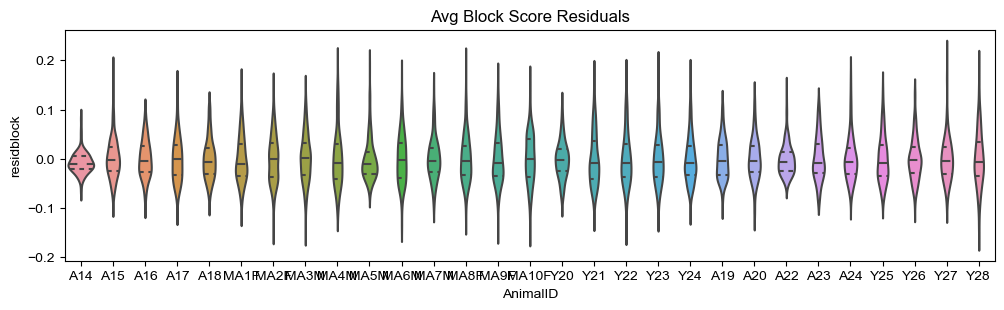

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ScoreAlt 
No. Observations:     7458        Method:                 REML     
No. Groups:           29          Scale:                  0.0068   
Min. group size:      79          Log-Likelihood:         4128.0038
Max. group size:      479         Converged:              Yes      
Mean group size:      257.2                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.111    0.012  8.936 0.000  0.087  0.136
C(AgeGroup)[T.2.0]        0.037    0.019  1.944 0.052 -0.000  0.073
C(AgeGroup)[T.3.0]        0.033    0.016  2.078 0.038  0.002  0.064
C(Sex)[T.M]               0.005    0.018  0.282 0.778 -0.031  0.041
C(Cohort)[T.D]            0.019    0.023  0.821 0.412 -0.026  0

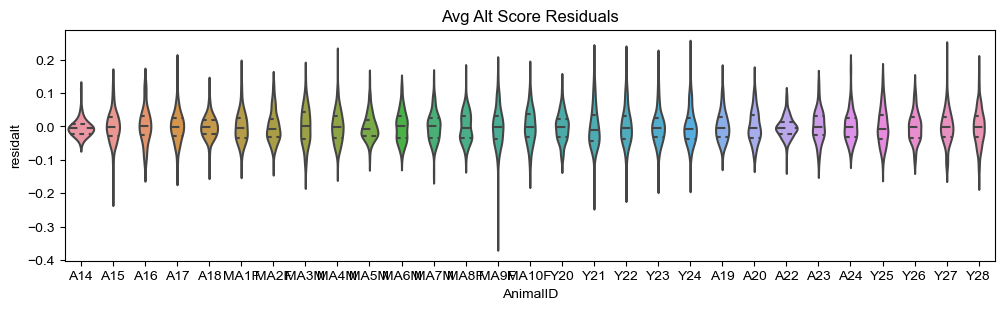

In [163]:
''' LMMs for Pos Speed Cell Score '''        
#gather dependent variables into lists
Score99Block = allscoreblock99
Score99Alt = allscorealt99
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Score99Block, Score99Alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','ScoreBlock','ScoreAlt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('ScoreBlock ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Score Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('ScoreAlt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
#print(malt.aic)
#print(malt.bic)

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt Score Residuals')
plt.show()

#Collect Fig 6 Source Data
#df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure6\6x.csv', index = False, header = True)

In [164]:
''' Get fitted block vs. alternation pos speed cell score session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

sscoreAfitted_seg_aged = [[] * r for i in range(r)]
sscoreAfitted_seg_MA = [[] * r for i in range(r)]
sscoreAfitted_seg_young = [[] * r for i in range(r)]
sscoreBfitted_seg_aged = [[] * r for i in range(r)]
sscoreBfitted_seg_MA = [[] * r for i in range(r)]
sscoreBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        animalidx = np.where(seshAanimal == m)[0][0]
        sessiona_idx = np.where(seshAanimal == m)[0]
        sessionb_idx = np.where(seshBanimal == m)[0]

        if m in SM_aged_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sscoreAfitted_seg_aged[idx] = np.append(sscoreAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1 
                sscoreBfitted_seg_aged[idx] = np.append(sscoreBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    

        elif m in SM_MA_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sscoreAfitted_seg_MA[idx] = np.append(sscoreAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sscoreBfitted_seg_MA[idx] = np.append(sscoreBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
        else:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sscoreAfitted_seg_young[idx] = np.append(sscoreAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sscoreBfitted_seg_young[idx] = np.append(sscoreBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


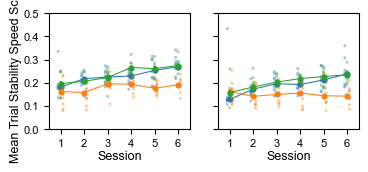

In [165]:
''' Composite Plot of Alternation Speed Score w/ Fitted Session Average Data Points'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.1,0.2,0.3,0.4,0.5])
ax[0].set_ylim([0.0,0.5])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Trial Stability Speed Score', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(sscoreAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, sscoreAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], sscoreAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, sscoreAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, sscoreBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], sscoreBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, sscoreBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'posscoresesh.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'posscoresesh.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.38346444817364056 0.5929223267540742 0.4535979397941295 0.5292604679874735
P [Young, MA, Aged, All]: 
0.004206541405674061 9.38505386841993e-07 0.0005716116929946221 2.286637061583627e-13

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2684393896968711 0.5543561814203055 0.2279742019422573 0.44368831477861276
P [Young, MA, Aged, All]: 
0.04968698688982762 6.333802725557758e-06 0.09732258184475942 2.135986112359453e-09

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.34988385241637904 0.5597139825143328 0.40061130532072003 0.5010637172132122
P [Young, MA, Aged, All]: 
0.0002057690873134075 6.503748525893045e-11 1.737584708379649e-05 1.6670085681454269e-22

n session halves: young, ma, aged
108 116 108


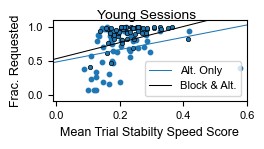

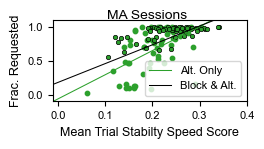

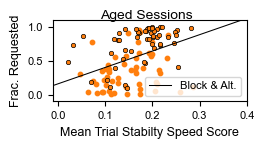

In [166]:
''' Plot Figure 6X with Block & Alt. Data '''
allidx = np.concatenate((y_sind99, ma_sind99, age_sind99))

#Linear regression with block data only
res = stats.linregress(sscoreblock99[y_sind99],reqblock_rates[y_sind99])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sscoreblock99[ma_sind99],reqblock_rates[ma_sind99])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sscoreblock99[age_sind99],reqblock_rates[age_sind99])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sscoreblock99[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sscorealt99[y_sind99],reqalt_rates[y_sind99])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sscorealt99[ma_sind99],reqalt_rates[ma_sind99])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sscorealt99[age_sind99],reqalt_rates[age_sind99])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sscorealt99[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sscoreblock99[y_sind99],sscorealt99[y_sind99])),np.hstack((reqblock_rates[y_sind99],reqalt_rates[y_sind99])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sscoreblock99[ma_sind99],sscorealt99[ma_sind99])),np.hstack((reqblock_rates[ma_sind99],reqalt_rates[ma_sind99])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sscoreblock99[age_sind99],sscorealt99[age_sind99])),np.hstack((reqblock_rates[age_sind99],reqalt_rates[age_sind99])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sscoreblock99[allidx],sscorealt99[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sind99)*2,len(ma_sind99)*2,len(age_sind99)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sscorealt99[y_sind99],reqalt_rates[y_sind99], color = 'C0', s = 10)
ax.scatter(sscoreblock99[y_sind99],reqblock_rates[y_sind99], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Trial Stabilty Speed Score', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.01,0.6])
ax.set_xticks([0,0.2,0.4,0.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'posscoreleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'posscoreleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sscorealt99[ma_sind99],reqalt_rates[ma_sind99], color = 'C2', s = 10)
ax.scatter(sscoreblock99[ma_sind99],reqblock_rates[ma_sind99], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Trial Stabilty Speed Score', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.01,0.4])
ax.set_xticks([0,0.1,0.2,0.3,0.4])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'posscoremiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'posscoremiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sscorealt99[age_sind99],reqalt_rates[age_sind99], color = 'C1', s = 10)
ax.scatter(sscoreblock99[age_sind99],reqblock_rates[age_sind99], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Trial Stabilty Speed Score', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.01,0.4])
ax.set_xticks([0,0.1,0.2,0.3,0.4])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'posscoreright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'posscoreright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Figure 2h
#print(list(sscoreblock99))
#print(list(reqblock_rates))
#print(list(sscorealt99))
#print(list(reqalt_rates))

In [148]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Neg Speed Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    if m in np.union1d(cohortc_mice,cohortd_mice):
    
        msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
        age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
        cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
        totalsesh = len(session)

        for i, s in enumerate(tdqm(session)):

            d = data[m][s]

            rawdata_file = 'RAW_' + m + '_' + s + '.npy'
            intn_file = 'intn_' + m + '_' + s + '.npy'
            
            raw = np.load(load_folder + rawdata_file, allow_pickle=True)
            cell_IDs = raw.item().get('cellsfil')
            d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
            intn = d['intn'].astype(bool)
            speedcell1 = d['speedcell1']
            speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)]

            for j, c in enumerate(speedcells1):
                cidx = np.append(cidx, totalcells)
                csex = np.append(csex, msex)
                cmice = np.append(cmice, m)
                ccount = np.append(ccount, (i + 1))
                cage = np.append(cage, age)
                ccohort = np.append(ccohort, cohort)

                totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ScoreBlock
No. Observations:     4088        Method:                 ML        
No. Groups:           29          Scale:                  0.0100    
Min. group size:      36          Log-Likelihood:         1508.8926 
Max. group size:      321         Converged:              Yes       
Mean group size:      141.0                                         
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                -0.180    0.017 -10.666 0.000 -0.213 -0.147
C(AgeGroup)[T.2.0]       -0.031    0.022  -1.426 0.154 -0.073  0.011
C(AgeGroup)[T.3.0]       -0.002    0.023  -0.080 0.936 -0.047  0.043
C(Sex)[T.M]              -0.025    0.014  -1.774 0.076 -0.052  0.003
Session:C(AgeGroup)[1.0] -0.010    0.003  -3.740 0

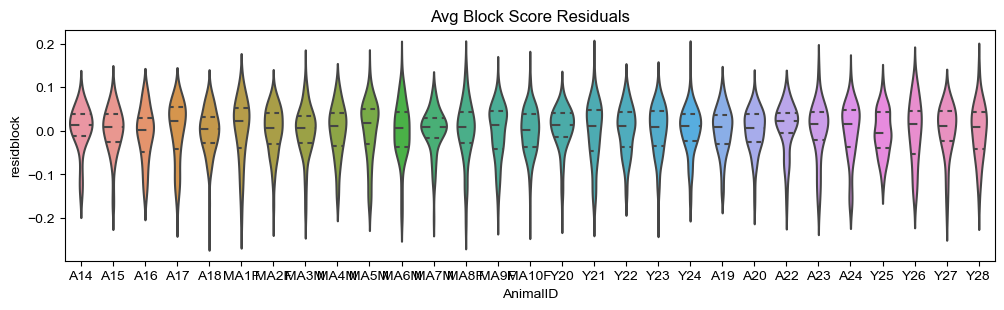

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ScoreAlt 
No. Observations:     4088        Method:                 ML       
No. Groups:           29          Scale:                  0.0111   
Min. group size:      36          Log-Likelihood:         1284.8815
Max. group size:      321         Converged:              Yes      
Mean group size:      141.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.166    0.018 -9.239 0.000 -0.201 -0.131
C(AgeGroup)[T.2.0]       -0.010    0.023 -0.420 0.675 -0.054  0.035
C(AgeGroup)[T.3.0]       -0.023    0.024 -0.938 0.348 -0.070  0.025
C(Sex)[T.M]              -0.015    0.015 -1.045 0.296 -0.044  0.014
Session:C(AgeGroup)[1.0] -0.015    0.003 -4.953 0.000 -0.020 -0

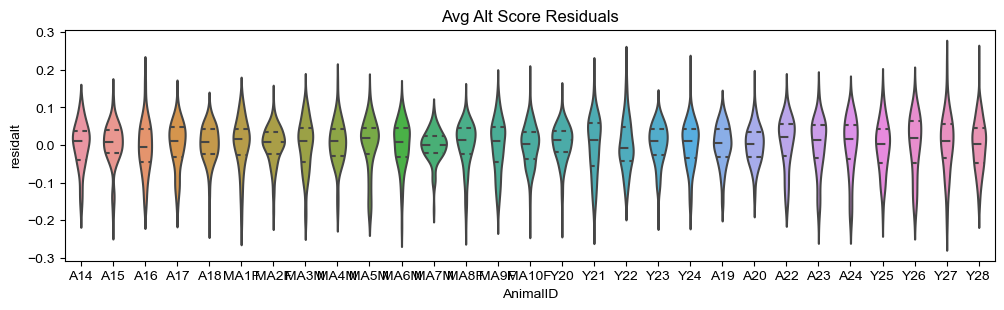

In [153]:
''' LMMs for Neg Speed Cell Score '''        
#gather dependent variables into lists
Score1Block = allscoreblock1
Score1Alt = allscorealt1
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Score1Block, Score1Alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','ScoreBlock','ScoreAlt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('ScoreBlock ~ 1 + C(AgeGroup) + C(Sex) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= False)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Score Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('ScoreAlt ~ 1 + C(AgeGroup) + C(Sex) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= False)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))
#print(malt.aic)
#print(malt.bic)

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt Score Residuals')
plt.show()

#Collect Fig 6 Source Data
#df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure6\6x.csv', index = False, header = True)

In [154]:
''' Get fitted block vs. alternation neg speed cell slope session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

sscoreAfitted_seg_aged = [[] * r for i in range(r)]
sscoreAfitted_seg_MA = [[] * r for i in range(r)]
sscoreAfitted_seg_young = [[] * r for i in range(r)]
sscoreBfitted_seg_aged = [[] * r for i in range(r)]
sscoreBfitted_seg_MA = [[] * r for i in range(r)]
sscoreBfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    if m in np.union1d(cohortc_mice, cohortd_mice):
    
        animalidx = np.where(seshAanimal == m)[0][0]
        sessiona_idx = np.where(seshAanimal == m)[0]
        sessionb_idx = np.where(seshBanimal == m)[0]

        if m in SM_aged_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sscoreAfitted_seg_aged[idx] = np.append(sscoreAfitted_seg_aged[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1 
                sscoreBfitted_seg_aged[idx] = np.append(sscoreBfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    

        elif m in SM_MA_mice:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sscoreAfitted_seg_MA[idx] = np.append(sscoreAfitted_seg_MA[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sscoreBfitted_seg_MA[idx] = np.append(sscoreBfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
        else:
            for i, c in enumerate(seshAcount[sessiona_idx]):
                idx = c.astype(int) - 1
                sscoreAfitted_seg_young[idx] = np.append(sscoreAfitted_seg_young[idx],seshAmean[sessiona_idx][i])
                sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)

            for i, c in enumerate(seshBcount[sessionb_idx]):
                idx = c.astype(int) - 1
                sscoreBfitted_seg_young[idx] = np.append(sscoreBfitted_seg_young[idx],seshBmean[sessionb_idx][i])
                sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
8 10 8

n aged, MA, young mice on day 1 for B
8 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


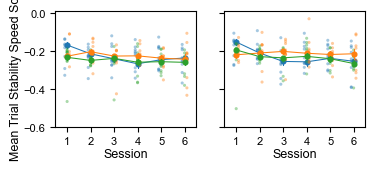

In [156]:
''' Composite Plot of Speed Slope w/ Fitted Session Average Data Points'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([-0.60,-0.40,-0.20,0])
ax[0].set_ylim([-0.6,0.01])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Trial Stability Speed Score', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(sscoreAfitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, sscoreAfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], sscoreAfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, sscoreAfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, sscoreBfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], sscoreBfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, sscoreBfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'negscoresesh.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'negscoresesh.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.034141356604975866 -0.22656867159181268 -0.22862254590977615 -0.19165759321331272
P [Young, MA, Aged, All]: 
0.8082403381524996 0.08721920419505164 0.09964071122104602 0.013952794006985276

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.011000691893163004 -0.11310636211435535 -0.036644500338405106 -0.09134084267205311
P [Young, MA, Aged, All]: 
0.9376857550283602 0.39791075150142474 0.7944764851845644 0.24474032202482818

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.02814559274548224 -0.16521256495225542 -0.15541261491759747 -0.14496263018784933
P [Young, MA, Aged, All]: 
0.7745736931907132 0.07634078703454823 0.11165896438209769 0.008556986458079775

n session halves: young, ma, aged
106 116 106


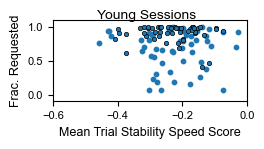

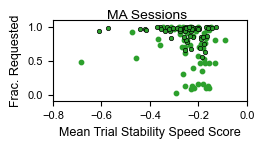

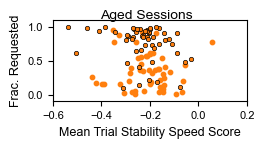

In [173]:
''' Plot Figure 6X with Block & Alt. Data '''
allidx = np.concatenate((y_sind1, ma_sind1, age_sind1))

#Linear regression with block data only
res = stats.linregress(sscoreblock1[y_sind1],reqblock_rates[y_sind1])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sscoreblock1[ma_sind1],reqblock_rates[ma_sind1])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sscoreblock1[age_sind1],reqblock_rates[age_sind1])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sscoreblock1[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sscorealt1[y_sind1],reqalt_rates[y_sind1])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sscorealt1[ma_sind1],reqalt_rates[ma_sind1])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sscorealt1[age_sind1],reqalt_rates[age_sind1])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sscorealt1[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sscoreblock1[y_sind1],sscorealt1[y_sind1])),np.hstack((reqblock_rates[y_sind1],reqalt_rates[y_sind1])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sscoreblock1[ma_sind1],sscorealt1[ma_sind1])),np.hstack((reqblock_rates[ma_sind1],reqalt_rates[ma_sind1])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sscoreblock1[age_sind1],sscorealt1[age_sind1])),np.hstack((reqblock_rates[age_sind1],reqalt_rates[age_sind1])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((sscoreblock1[allidx],sscorealt1[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sind1)*2,len(ma_sind1)*2,len(age_sind1)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sscorealt1[y_sind1],reqalt_rates[y_sind1], color = 'C0', s = 10)
ax.scatter(sscoreblock1[y_sind1],reqblock_rates[y_sind1], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Trial Stability Speed Score', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.6,0.0])
ax.set_xticks([-0.6,-0.4,-0.2,0])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'negscoreleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'negscoreleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sscorealt1[ma_sind1],reqalt_rates[ma_sind1], color = 'C2', s = 10)
ax.scatter(sscoreblock1[ma_sind1],reqblock_rates[ma_sind1], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Trial Stability Speed Score', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.8,0.0])
ax.set_xticks([-0.8,-0.6,-0.4,-0.2,0])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
#ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'negscoremiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'negscoremiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sscorealt1[age_sind1],reqalt_rates[age_sind1], color = 'C1', s = 10)
ax.scatter(sscoreblock1[age_sind1],reqblock_rates[age_sind1], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Trial Stability Speed Score', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([-0.6,0.2])
ax.set_xticks([-0.6,-0.4,-0.2,0,0.2])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
#ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
#ax.legend(fontsize = 8)
plt.savefig(save_folder + 'negscoreright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'negscoreright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Print Source Data for Figure 2h
#print(list(sscoreblock1))
#print(list(reqblock_rates))
#print(list(sscorealt1))
#print(list(reqalt_rates))

# Examine grid scale gradients in MEC

In [33]:
'''Define which mice & sessions to load based on metadata'''

#note that here we are loading in all sessions that have dark data and distance-tuning shuffle scores 
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [34]:
''' From session metadata, get max depth of probe tip'''

for m, session in zip(mice,sessions):
    seshcount = 1
    for s in session:
        d = data[m][s]
        
        #define LFP folder
        MECmaxdepth = np.array(sessionmeta.loc[((sessionmeta.Animal_ID == m) & ((sessionmeta.Session == seshcount))), 'Final Depth (D)'])[0]
        d['MECmaxdepth'] = MECmaxdepth
        
        seshcount += 1

In [35]:
''' Load in grid cell IDs for Split Maze Sessions (previously generated)'''
for m, session in zip(mice,sessions):

    for s in session:
        d = data[m][s]
        
        #load Split Maze grid cell boolean from Figure 2/S3 Notebook output
        gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        gridcell = np.load(figs2_folder + gridcell_file)
        gridcell = gridcell.astype(bool)
        d['gridcell'] = gridcell

# Estimate grid scale, calculate depth along the probe relative to brain surface among classified grid cells, and plot Figure 6F OR skip to next section

In [ ]:
''' Calculate each grid cell's depth from surface and estimated grid scale; plot panels of Figure 6f '''

#parameters 
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20
lag_max = 800
lags = np.arange(0,801,1)
n_dark = 20 #trials

ex_mice = ['Y21','MA9F','A15']
ex_sessions = ['091822_record1','111522_record3','090122_record3']

#arrays to save data
aprefdist = []
maprefdist = []
yprefdist = []
aaspikedepth = []
maaspikedepth = []
yaspikedepth = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
            
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        #call in data needed to calculate spike depths for each cell based on templates
        sp = raw.item().get('sp')
        temps = sp['temps'].copy() #nTemplates x nTimepoints x nChannels
        winv = sp['winv'].copy() #nCh x nCh
        ycoords = sp['ycoords'].copy() #nCh
        templates = sp['spikeTemplates'].copy() #nSpikes
        cluster_id = sp['clu'].copy() #nSpikes

        #Get spike depths
        spikeDepths = get_spike_depths(temps, winv, ycoords, templates) #distance from tip (lower = more ventral)

        gridcelldepths = []
        for i, c in enumerate(gridcells):
            gridcelldepths = np.append(gridcelldepths, np.median(spikeDepths[cluster_id == c]))
        d['gridcelldepths'] = gridcelldepths

        #load in maximal depth from surface of probe tip from session metadata
        MECmaxdepth = d['MECmaxdepth']
        adjgridcelldepths = MECmaxdepth - gridcelldepths
        d['adjgridcelldepths'] = adjgridcelldepths 

        ##Get preferred distance for each grid cell based on dark autocorrelation
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b = 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        prefdist = [] #stored lag of max peak
        norm_auto = np.zeros([gridcells.shape[0],lags.shape[0]]) #for plotting
        for i, c in enumerate(gridcells):
            sdx = np.where(cell_IDs == c)[0][0]

            autocorrelation = get.autocorr(FR[sdx,:], lags)
            normauto = (autocorrelation - np.min(autocorrelation)) / (np.max(autocorrelation) - np.min(autocorrelation))
            norm_auto[i,:] = normauto
            peaks, _ = find_peaks(normauto, width = 8, height = 0.05, prominence = 0.05)
            prefdist = np.append(prefdist, peaks[0])

        #save estimated grid scale into data dictionary 
        d['prefdist'] = prefdist 
        
        #save data & set color for example plots
        if m in SM_aged_mice:
            aprefdist = np.append(aprefdist,prefdist)
            aaspikedepth = np.append(aaspikedepth, adjgridcelldepths)
            col = 'C1'
        elif m in SM_MA_mice:
            maprefdist = np.append(maprefdist,prefdist)
            maaspikedepth = np.append(maaspikedepth, adjgridcelldepths)
            col = 'C2'
        elif m in SM_young_mice:
            yprefdist = np.append(yprefdist,prefdist)
            yaspikedepth = np.append(yaspikedepth, adjgridcelldepths)
            col = 'C0'   

        # if this is an example session, plot panel of Figure 6F
        if (m in ex_mice) and (s in ex_sessions):

            #sort norm auto inversely by spike depth
            sort_idx = np.argsort(gridcelldepths)

            sortnorm_auto = np.zeros([gridcells.shape[0],lags.shape[0]])
            for i in range(0,sortnorm_auto.shape[0]):
                sortnorm_auto[i,:] = norm_auto[sort_idx[i],:]

            #plot session grid cell dark FR autocorrelation heatmaps,  sorted by inversely by spike depth
            fig, ax = plt.subplots()
            fig.set_size_inches(2,3)
            ax.imshow(sortnorm_auto, clim = [0, 0.4], cmap='summer')
            ax.set_xticks(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_xticklabels(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_title(str(m) + '_S' + str(s[-1]), fontsize=10, pad=5, color = col)
            ax.set_xlabel('Lag (cm)', fontsize=9, labelpad=1)
            ax.set_ylabel('Grid Cell (Ventral to Dorsal)', fontsize=9, labelpad=1)
            ax.tick_params(which='major', labelsize=8, pad=0.5)
            im = ax.imshow(sortnorm_auto, clim=[0, 0.4], aspect='auto', cmap='summer')
            cbar = fig.colorbar(im)
            cbar.ax.tick_params(labelsize = 8)
            fig.savefig(save_folder + m + '_' + s + '_6F.png', dpi=400, bbox_inches='tight')
            fig.savefig(save_folder + m + '_' + s + '_6F.svg', dpi=400, bbox_inches='tight')
            plt.show()

In [ ]:
'''Save Out Info if Calculated for the first time above'''

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]      
        
        prefdist = d['prefdist']
        prefdist_file = 'prefdist_' + str(m) + '_' + str(s) + '.npy'
        np.save(save_folder + prefdist_file, prefdist)
        
        gridcelldepths = d['gridcelldepths']
        depths_file = 'depths_' + str(m) + '_' + str(s) + '.npy'
        np.save(save_folder + depths_file, gridcelldepths)

# Load estimated grid scale & depth if previously calculated & plot Figure 6F

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

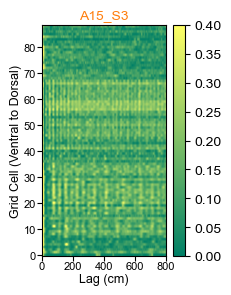

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

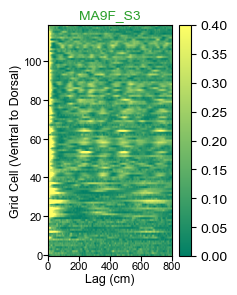

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

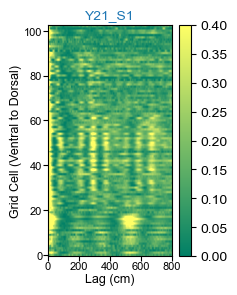

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [36]:
''' Calculate each grid cell's depth from surface and estimated grid scale; plot panels of Figure 6f '''

#parameters 
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20
lag_max = 800
lags = np.arange(0,801,1)
n_dark = 20 #trials

ex_mice = ['Y21','MA9F','A15']
ex_sessions = ['091822_record1','111522_record3','090122_record3']

#arrays to save data
aprefdist = []
maprefdist = []
yprefdist = []
aaspikedepth = []
maaspikedepth = []
yaspikedepth = []

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
                
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell] 
        
        #load estimated grid scales & unit depths
        prefdist_file = 'prefdist_' + str(m) + '_' + str(s) + '.npy'
        d['prefdist'] = np.load(save_folder + prefdist_file)
        prefdist = d['prefdist']

        depths_file = 'depths_' + str(m) + '_' + str(s) + '.npy'
        d['gridcelldepths'] = np.load(save_folder + depths_file)
        gridcelldepths = d['gridcelldepths']
        
        #adjust depth to be relative to brain surface along probe using session metadata
        MECmaxdepth = d['MECmaxdepth']
        adjgridcelldepths = MECmaxdepth - gridcelldepths
        d['adjgridcelldepths'] = adjgridcelldepths 
        
        #save data & set color for example plots
        if m in SM_aged_mice:
            aprefdist = np.append(aprefdist,prefdist)
            aaspikedepth = np.append(aaspikedepth, adjgridcelldepths)
            col = 'C1'
        elif m in SM_MA_mice:
            maprefdist = np.append(maprefdist,prefdist)
            maaspikedepth = np.append(maaspikedepth, adjgridcelldepths)
            col = 'C2'
        elif m in SM_young_mice:
            yprefdist = np.append(yprefdist,prefdist)
            yaspikedepth = np.append(yaspikedepth, adjgridcelldepths)
            col = 'C0'   

        # if this is an example session, plot panel of Figure 6F
        if ((m in ex_mice) and (s in ex_sessions)):
            
            ##Get preferred distance for each grid cell based on dark autocorrelation
            #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
            FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, b = 2, sigma = 2, smooth=True, normalize=True, occupancy=True)
            stop_idx = np.where(trials == n_dark)[0][0]
            FR = FR[:stop_idx,:,:]
            n_trials = FR.shape[0]
            n_pos = FR.shape[1]
            n_cells = FR.shape[2]
            FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T

            #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
            norm_auto = np.zeros([gridcells.shape[0],lags.shape[0]]) #for plotting
            
            for i, c in enumerate(gridcells):
                sdx = np.where(cell_IDs == c)[0][0]

                autocorrelation = get.autocorr(FR[sdx,:], lags)
                normauto = ((autocorrelation - np.min(autocorrelation)) / (np.max(autocorrelation) - np.min(autocorrelation)))
                norm_auto[i,:] = normauto

                #sort norm auto inversely by spike depth
                sort_idx = np.argsort(gridcelldepths)

                sortnorm_auto = np.zeros([gridcells.shape[0],lags.shape[0]])
                for i in range(0,sortnorm_auto.shape[0]):
                    sortnorm_auto[i,:] = norm_auto[sort_idx[i],:]

            #plot session grid cell dark FR autocorrelation heatmaps,  sorted by inversely by spike depth
            fig, ax = plt.subplots()
            fig.set_size_inches(2,3)
            ax.imshow(sortnorm_auto, clim = [0, 0.4], cmap='summer')
            ax.set_xticks(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_xticklabels(np.arange(0, lag_max +  400//b, 400//b))
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_title(str(m) + '_S' + str(s[-1]), fontsize=10, pad=5, color = col)
            ax.set_xlabel('Lag (cm)', fontsize=9, labelpad=1)
            ax.set_ylabel('Grid Cell (Ventral to Dorsal)', fontsize=9, labelpad=1)
            ax.tick_params(which='major', labelsize=8, pad=0.5)
            im = ax.imshow(sortnorm_auto, clim=[0, 0.4], aspect='auto', cmap='summer')
            cbar = fig.colorbar(im)
            #cbar.ax.tick_params(labelsize = 8)
            fig.savefig(save_folder + m + '_' + s + '_6F.png', dpi=400, bbox_inches='tight')
            fig.savefig(save_folder + m + '_' + s + '_6F.svg', dpi=400, bbox_inches='tight')
            plt.show()

# Compare grid scale distributions across age groups (Figures 6G-J)

In [37]:
'''Report Number of Grid Cells in each Age Group'''

print('n grid cells young, MA, aged: ')
print(len(yprefdist), len(maprefdist), len(aprefdist))

n grid cells young, MA, aged: 
2441 2035 2032


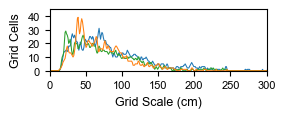

In [40]:
''' Plot Histograms of Grid Cell Preferred Distance (Figure 6G) '''
lagbins = np.arange(0,801,1)
fig, ax = plt.subplots(figsize = (2.8,0.8))

y, bin_edges = np.histogram(yprefdist, bins = lagbins)
y = gaussian_filter1d(y, sigma = 1)
bincenters = 0.5 *(bin_edges[1:] + bin_edges[:-1])
ax.plot(bincenters, y, '-', linewidth = 0.75, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(maprefdist, bins = lagbins)
ma = gaussian_filter1d(ma, sigma = 1)
bincenters = 0.5 *(bin_edges[1:] + bin_edges[:-1])
ax.plot(bincenters, ma, '-', linewidth = 0.75, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(aprefdist, bins = lagbins)
a = gaussian_filter1d(a, sigma = 1)
bincenters = 0.5 *(bin_edges[1:] + bin_edges[:-1])
ax.plot(bincenters, a, '-', linewidth = 0.75, color = 'C1', label = 'Aged')

#plt.title('Grid Cell Pref Dist by Age Group', fontsize = 10)
plt.ylabel('Grid Cells', fontsize = 9)
plt.xlabel('Grid Scale (cm)', fontsize = 9)
ax.set_xlim(0,300)
ax.set_ylim(0,45)
ax.set_yticks([0,10,20,30,40])
ax.tick_params(labelsize = 8)
#plt.legend()
plt.savefig(save_folder + '6G.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6G.svg', dpi=400, bbox_inches='tight')
plt.show()

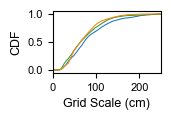

In [41]:
''' Plot 6h (left)'''

lagbins = np.arange(0,801,1)
#fig, ax = plt.subplots(figsize = (8,2))
fig, ax = plt.subplots(figsize = (1.4,0.8))

y, bin_edges = np.histogram(yprefdist, bins = lagbins)
y = gaussian_filter1d(y, sigma = 1)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax.plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(maprefdist, bins = lagbins)
ma = gaussian_filter1d(ma, sigma = 1)
pdf = ma / sum(ma)
cdfma = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfma, '-', linewidth = 0.75, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(aprefdist, bins = lagbins)
a = gaussian_filter1d(a, sigma = 1)
pdf = a / sum(a)
cdfa = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfa, '-', linewidth = 0.75, color = 'C1', label = 'Aged')

#plt.title('Grid Scale', fontsize = 10)
plt.ylabel('CDF', fontsize = 9)
plt.xlabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax.set_yticks([0,0.5,1.0])
plt.xlim([0,250])
plt.savefig(save_folder + '6Hleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Hleft.svg', dpi=400, bbox_inches='tight')
plt.show()

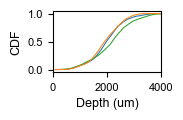

In [42]:
''' Plot 6h (right) '''
depthbins = np.arange(0,4500,100)
#fig, ax = plt.subplots(figsize = (8,2))
fig, ax = plt.subplots(figsize = (1.4,0.8))

y, bin_edges = np.histogram(yaspikedepth, bins = depthbins)
#y = gaussian_filter1d(y, sigma = 1)
pdf = y / sum(y)
ycdf = np.cumsum(pdf)
ax.plot(bin_edges[1:], ycdf, '-', linewidth = 0.75, color = 'C0', label = 'Young')

ma, bin_edges = np.histogram(maaspikedepth, bins = depthbins)
#ma = gaussian_filter1d(ma, sigma = 1)
pdf = ma / sum(ma)
cdfma = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfma, '-', linewidth = 0.75, color = 'C2', label = 'MA')

a, bin_edges = np.histogram(aaspikedepth, bins = depthbins)
#a = gaussian_filter1d(a, sigma = 1)
pdf = a / sum(a)
cdfa = np.cumsum(pdf)
ax.plot(bin_edges[1:], cdfa, '-', linewidth = 0.75, color = 'C1', label = 'Aged')

plt.ylabel('CDF', fontsize = 9)
plt.xlabel('Depth (um)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax.set_yticks([0,0.5,1.0])
plt.xlim([0,4000])
#plt.legend()
plt.savefig(save_folder + '6Hright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Hright.svg', dpi=400, bbox_inches='tight')
plt.show()

#Print Source Data Figure 6h
#print(list(yprefdist))
#print(list(maprefdist))
#print(list(aprefdist))

#print(list(yaspikedepth))
#print(list(maaspikedepth))
#print(list(aaspikedepth))

In [43]:
''' Statistics for Grid Cell Depth & Scale'''

print('\nGRID CELL SCALE DIFFERENCES RESULTS KS:')
res = stats.ks_2samp(aprefdist,yprefdist, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(maprefdist,yprefdist, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('MA vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(aprefdist,maprefdist, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. MA CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

print('\nGRID CELL DEPTH RESULTS KS:')
res = stats.ks_2samp(aaspikedepth,yaspikedepth, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(maaspikedepth,yaspikedepth, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('MA vs. Y CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))

res = stats.ks_2samp(aaspikedepth,maaspikedepth, alternative = 'two-sided')
stat = res.statistic; p_value = res.pvalue; loc = res.statistic_location; sign = res.statistic_sign
print('A vs. MA CDF: Stat ' + str(stat) + ', p=' + str(p_value) + ', sign=' + str(sign) + ', loc=' + str(loc))


GRID CELL SCALE DIFFERENCES RESULTS KS:
A vs. Y CDF: Stat 0.11816608173363827, p=5.999841443610253e-14, sign=1, loc=100.0
MA vs. Y CDF: Stat 0.08537987915292299, p=1.7159836321005622e-07, sign=1, loc=54.0
A vs. MA CDF: Stat 0.07599368337557313, p=1.4597267925198267e-05, sign=-1, loc=35.0

GRID CELL DEPTH RESULTS KS:
A vs. Y CDF: Stat 0.05705697774566381, p=0.0013888506389229897, sign=1, loc=1795.0792663712589
MA vs. Y CDF: Stat 0.1440624789252401, p=1.489353821564416e-20, sign=-1, loc=2138.3676292767577
A vs. MA CDF: Stat 0.18273520478244887, p=3.5347856818413605e-30, sign=1, loc=2105.64946725254


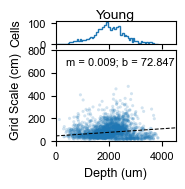

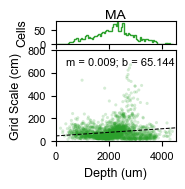

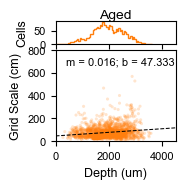

In [44]:
''' Plot Scatter Plots of Pref Dist vs. Distance from Surface Sampling by Age Groups (Figure 6I) '''

#define plotting function for vertically stacked histogram 
def scatter_histx(x, y, ax, ax_histx, col, sz = 5):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom = False)

    # the scatter plot:
    ax.scatter(x, y, s = sz, color = col, alpha = 0.2, edgecolor = 'None')

    # now determine nice limits by hand:
    binwidth = 50
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-2000, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, orientation='vertical', histtype = 'step', color = col)

#get some linear fits:
aslope, ayint, ar, _, _  = stats.linregress(aaspikedepth, aprefdist)
maslope, mayint, mar, _, _  = stats.linregress(maaspikedepth, maprefdist)
yslope, yyint, yr, _, _  = stats.linregress(yaspikedepth, yprefdist)

#Plot 6I (left)
fig = plt.figure(figsize=(1.5, 1.5))
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
scatter_histx(yaspikedepth, yprefdist, ax, ax_histx, col = 'C0', sz = 5)
ax.set_xlim([0,4500])
ax.set_ylim([0,800])
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope*X_plot + ayint, '--', color = 'k', linewidth = 0.75)
ax.set_xlabel('Depth (um)', fontsize = 9)
ax.set_ylabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax_histx.tick_params(labelsize = 8)
ax_histx.set_ylabel('Cells', fontsize = 9)
plt.text(400, -100, 'm = ' + str(np.round(yslope, 3)) + '; b = ' + str(np.round(yyint, 3)), fontsize = 8)
fig.suptitle('Young', fontsize = 10)
plt.savefig(save_folder + '6Ileft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Ileft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot 6I (middle)
fig = plt.figure(figsize=(1.5, 1.5))
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
scatter_histx(maaspikedepth, maprefdist, ax, ax_histx, col = 'C2', sz = 5)
ax.set_xlim([0,4500])
ax.set_ylim([0,800])
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope*X_plot + ayint, '--', color = 'k', linewidth = 0.75)
ax.set_xlabel('Depth (um)', fontsize = 9)
ax.set_ylabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
ax_histx.tick_params(labelsize = 8)
ax_histx.set_ylabel('Cells', fontsize = 9)
plt.text(400, -75, 'm = ' + str(np.round(maslope, 3)) + '; b = ' + str(np.round(mayint, 3)), fontsize = 8)
fig.suptitle('MA', fontsize = 10)
plt.savefig(save_folder + '6Imiddle.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Imiddle.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot 6I (right)
fig = plt.figure(figsize=(1.5, 1.5))
gs = fig.add_gridspec(2, 1,  height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex = ax)
scatter_histx(aaspikedepth, aprefdist, ax, ax_histx, col = 'C1', sz = 5)
ax.set_xlim([0,4500])
ax.set_ylim([0,800])
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope*X_plot + ayint, '--', color = 'k', linewidth = 0.75)
ax.set_xlabel('Depth (um)', fontsize = 9)
ax.set_ylabel('Grid Scale (cm)', fontsize = 9)
ax.tick_params(labelsize = 8)
plt.text(400, -75, 'm = ' + str(np.round(aslope, 3)) + '; b = ' + str(np.round(ayint, 3)), fontsize = 8)
fig.suptitle('Aged', fontsize = 10)
ax_histx.tick_params(labelsize = 8)
ax_histx.set_ylabel('Cells', fontsize = 9)
plt.savefig(save_folder + '6Iright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '6Iright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [45]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
alldists = []
alldepths = []
alladjdepths = []
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        prefdist = d['prefdist']
        alldists = np.append(alldists, prefdist)
        
        depths = d['gridcelldepths']
        alldepths = np.append(alldepths, depths)
        
        adjdepths = d['adjgridcelldepths']
        alladjdepths = np.append(alladjdepths, adjdepths)
        
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Cohort = list(ccohort)
Age_Group = list(cage)
Cell_ID = list(cidx)
        
#gather dependent variables into lists
Dists = list(alldists)
Depths = list(alldepths)
Adjdepths = list(alladjdepths)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Dists      
No. Observations:       6508          Method:                   REML       
No. Groups:             29            Scale:                    1308.2062  
Min. group size:        60            Log-Likelihood:           -35699.3111
Max. group size:        446           Converged:                Yes        
Mean group size:        224.4                                              
---------------------------------------------------------------------------
                              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                      79.300    8.327  9.523 0.000  62.980  95.621
C(AgeGroup)[T.2.0]              1.393   12.563  0.111 0.912 -23.230  26.016
C(AgeGroup)[T.3.0]            -49.532   10.873 -4.556 0.000 -70.843 -28.222
C(Cohort)[T.D]                 

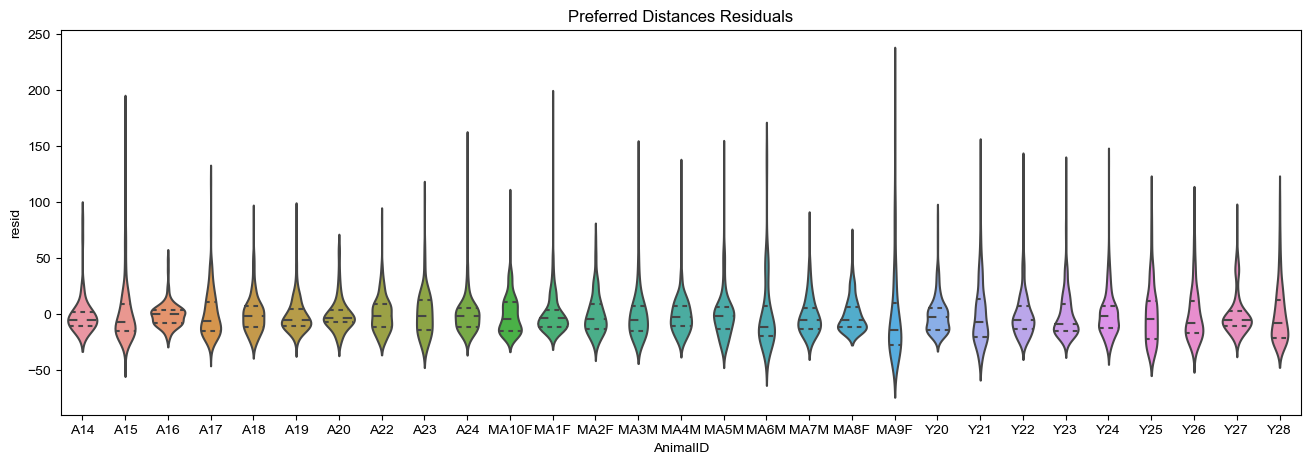

Raw Data Mean across All Sessions by Animal:
AnimalID
 62.633333
 91.836957
 65.494505
 89.818713
 81.659664
 64.953704
 62.067568
 76.779592
 92.184932
 69.916905
 62.410256
 63.269231
 76.289683
 70.484127
 73.014815
108.322709
103.723270
 76.528090
 58.908654
132.566102
 68.594203
117.064327
 76.815190
 76.223684
 99.504484
103.013699
100.801527
 79.905882
 82.555046

Fitted Data Mean across All Sessions by Animal:
AnimalID
A14       63.258491
A15       91.685457
A16       65.983071
A17       89.656456
A18       81.585127
A19       65.251372
A20       62.362975
A22       76.643239
A23       91.751540
A24       69.939637
MA10F     62.778924
MA1F      63.400420
MA2F      76.294482
MA3M      70.901108
MA4M      73.356687
MA5M     108.004737
MA6M     103.235680
MA7M      77.187028
MA8F      59.276063
MA9F     131.883325
Y20       68.902582
Y21      116.767592
Y22       76.965854
Y23       76.402380
Y24       99.407315
Y25      102.809464
Y26      100.459052
Y27       80.016697
Y28      

In [46]:
''' LMM for Grid Scale & Report Results for Figure 8

Note: this model did not converge

'''

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Cohort, Age_Group, Dists, Depths, Adjdepths))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'Cohort', 'AgeGroup','Dists','Depths','Adjdepths'])

#handle NaNs
df = df.dropna()

# Dist Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mdist = smf.mixedlm('Dists ~ 1 + C(AgeGroup) + C(Cohort) + C(Sex) + Adjdepths + Adjdepths:C(AgeGroup) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc, data=df).fit(reml = True)
print(mdist.summary())
print(mdist.wald_test_terms(scalar = False))
#print(mdist.aic)
#print(mdist.bic)

'''
## Optional Additional Residual Plots
residuals = mdist.resid
fig, axes = plt.subplots(1,3, figsize=(10, 3))

# Residual vs. Fitted values
axes[0].scatter(mdist.fittedvalues, residuals)
axes[0].set_xlabel("Fitted values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Fitted Values")

# Residual vs. Age Group
axes[1].scatter(df['AgeGroup'], residuals)
axes[1].set_xlabel("AgeGroup")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals vs AgeGroup")

# Q-Q Plot
sm.qqplot(residuals, ax = axes[2])
axes[2].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
'''

#plots of residuals
df['resid'] = mdist.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Preferred Distances Residuals')
plt.show()

#Print Results for Figure 8
df['fitted'] = mdist.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Dists'].mean().to_string(index=False))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

#Collect Fig 6j Source Data
df.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure6\6j.csv', index = False, header = True)

# Sig. session x age effects... Therefore, reporting change in mean across sessions
print('\nFitted Data Mean across All Sessions by Animal:')
print('First Three: ')
print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
print('Last Three: ')
print(df.loc[df['Session'] >= 4].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))

C:\Users\Python\AppData\Local\Temp\ipykernel_17412\338951749.py:24: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data = animalmeta, x = 'Age_Group', y = 'meangridscale', ax = ax, palette = pal, size = 5)


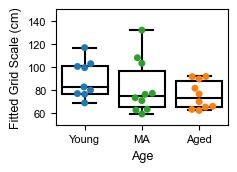

In [48]:
''' Plot LMM Fitted Mean Grid Scale by Animal (Figure 6j)'''

new_palette =  sns.color_palette(n_colors = 3)
new_palette[1], new_palette[2] = new_palette[2], new_palette[1]
df['gridscale'] = mdist.fittedvalues

animalgrouped = df.groupby('AnimalID')
animalscales = animalgrouped['gridscale'].mean()
scales = np.array(animalscales)
    
#save sorted output to animal metadata csv
for i, c in enumerate(scales):
    m = animalscales.index[i]
    animalmeta.loc[np.where(animalmeta.Animal_ID == str(m))[0][0], 'meangridscale'] = c
    
#Save out Plotted Data for Figure 6j
animalmeta.to_csv(r'C:\Users\Python\Desktop\LocalData\Figure6\6j_part2.csv', index = False, header = True)
    
#Plot Figure 6j
tab10 = sns.color_palette("tab10")
pal = {tab10[0],tab10[2],tab10[1]}

fig, ax = plt.subplots(figsize = (2.215,1.5))
sns.boxplot(data = animalmeta, x = 'Age_Group', y = 'meangridscale', ax = ax, boxprops = {'facecolor': 'none', 'edgecolor':'black'},
               medianprops = {'color': 'black'}, whiskerprops = {'color': 'black'}, capprops = {'color': 'black'}, dodge = False)
sns.swarmplot(data = animalmeta, x = 'Age_Group', y = 'meangridscale', ax = ax, palette = pal, size = 5)
ax.set_ylabel('Fitted Grid Scale (cm)', fontsize = 9)
ax.set_xlabel('Age', fontsize = 9)
ax.set_xticklabels(['Young','MA','Aged'])
ax.tick_params(labelsize = 8)
ax.set_ylim(50,150)
plt.savefig(save_folder + '6J.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '6J.svg', dpi = 400, bbox_inches = 'tight')
plt.show()